In [17]:
import mlxtend
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import pandas_ml
from pandas_ml import ConfusionMatrix

In [19]:
import os
from sklearn.utils import shuffle
import glob
import sys
################### DATASET HANDLING ####################
DATASET_PATH = "/home/dic/jupyter/train_binary4" #change the path to your dataset folder here
DATASET_PATH1 = "/home/dic/jupyter/train_CRTS_on_OGLE"
    
def parseDataset():
 
    #we use subfolders as class labels
    classes = [folder for folder in sorted(os.listdir(DATASET_PATH))]
    classes1 = [folder for folder in sorted(os.listdir(DATASET_PATH1))]
    #now we enlist all image paths
    images1=[]
    images = []
    for c in classes:
        images += ([os.path.join(DATASET_PATH, c, path) for path in os.listdir(os.path.join(DATASET_PATH, c))])
    #print(images)
    
    for b in classes1:
        images1 += ([os.path.join(DATASET_PATH1, b, path) for path in os.listdir(os.path.join(DATASET_PATH1, b))])
        
    #shuffle image paths
    images = shuffle(images, random_state=80)
    images1 = shuffle(images1, random_state=80)
 
    #we want to use a 15% validation split
    vsplit = int(len(images) * 0.15)
    train = images[:-vsplit]
    val = images[-vsplit:]
    
    dtest= int(len(images1))
    
    #train = images[:vsplit] #everything except the last vsplit items in the array 
    #val = images[vsplit:msplit]  #only last vsplit items from the array
    test=images1[0:dtest]
    #show some stats
    print ("CLASS LABELS:", classes)
    print ("TRAINING IMAGES:", len(train))
    print ("VALIDATION IMAGES:", len(val))
    print ("TEST IMAGES:", len(test))
    return classes, train, val,test
 
#parse dataset
CLASSES, TRAIN, VAL,TEST = parseDataset()


CLASS LABELS: ['LPV', 'RRLYR']
TRAINING IMAGES: 24261
VALIDATION IMAGES: 4281
TEST IMAGES: 8864


In [20]:
import lasagne
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh

In [21]:
import os
import time
from sklearn.utils import shuffle

import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import itertools

from lasagne import random as lasagne_random
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh
from lasagne import objectives
from lasagne import updates

import theano
import theano.tensor as T

import warnings
warnings.filterwarnings("ignore")


In [22]:
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh
 
################## BUILDING THE MODEL ###################
def buildModel():
    #this is our input layer with the inputs (None, dimensions, width, height)
    l_input = layers.InputLayer((None, 3, 22, 23))
    
    #first convolutional layer, has l_input layer as incoming and is followed by a pooling layer
    l_conv1 = layers.Conv2DLayer(l_input, num_filters=32, filter_size=3, nonlinearity=lasagne.nonlinearities.rectify)
    
    #l_pool = layers.MaxPool2DLayer(l_conv1, pool_size=2)
    
    l_drop1= layers.DropoutLayer(l_conv1,  p=0.1)
    
    #l_dense1 = layers.DenseLayer(l_drop1, num_units=128)
    
    #l_conv2 = layers.Conv2DLayer(l_drop1, num_filters=128, filter_size=5, nonlinearity=lasagne.nonlinearities.rectify)
    
   
    #l_conv3 = layers.Conv2DLayer(l_conv2, num_filters=256, filter_size=5, nonlinearity=lasagne.nonlinearities.rectify)
    
    l_dense2 = layers.DenseLayer(l_drop1, num_units=128)
    
    l_drop2= layers.DropoutLayer(l_dense2,  p=0.25)
    
    l_dense2 = layers.DenseLayer(l_drop2, num_units=128)
    
    l_output = layers.DenseLayer(l_dense2, num_units=2, nonlinearity=lasagne.nonlinearities.softmax)
    
    #let's see how many params our net has
    print ("MODEL HAS", layers.count_params(l_output), "PARAMS")
    
    #we return the layer stack as our network by returning the last layer
    return l_output


NET = buildModel()


MODEL HAS 1738114 PARAMS


In [23]:
from lasagne import objectives
 
import theano
import theano.tensor as T
 
#################### LOSS FUNCTION ######################
def calc_loss(prediction, targets):
 
    #categorical crossentropy is the best choice for a multi-class softmax output
    l = T.mean(objectives.categorical_crossentropy(prediction, targets))
    
    return l
 
#theano variable for the class targets
#this is the output vector the net should predict
targets = T.matrix('targets', dtype=theano.config.floatX)
 
#get the network output
prediction = layers.get_output(NET)
 
#calculate the loss
loss = calc_loss(prediction, targets)

In [24]:
################# ACCURACY FUNCTION #####################
def calc_accuracy(prediction, targets):
 
    #we can use the lasagne objective categorical_accuracy to determine the top1 accuracy
    a = T.mean(objectives.categorical_accuracy(prediction, targets, top_k=1))
    
    return a
 
accuracy = calc_accuracy(prediction, targets)

In [25]:
from lasagne import updates
 
####################### UPDATES #########################
#get all trainable parameters (weights) of our net
params = layers.get_all_params(NET, trainable=True)
 
#we use the adam update
#it changes params based on our loss function with the learning rate
param_updates = updates.adam(loss, params, learning_rate=0.0002)

In [26]:
import theano
#################### TRAIN FUNCTION ######################
#the theano train functions takes images and class targets as input
#it updates the parameters of the net and returns the current loss as float value
#compiling theano functions may take a while, you might want to get a coffee now...
print ("COMPILING THEANO TRAIN FUNCTION...",)
train_net = theano.function([layers.get_all_layers(NET)[0].input_var, targets], loss, updates=param_updates)
print ("DONE!")
 
################# PREDICTION FUNCTION ####################
#we need the prediction function to calculate the validation accuracy
#this way we can test the net after training
#first we need to get the net output
net_output = layers.get_output(NET)
 
#now we compile another theano function; this may take a while, too
print ("COMPILING THEANO TEST FUNCTION...",)
test_net = theano.function([layers.get_all_layers(NET)[0].input_var, targets], [net_output, loss, accuracy])
print ("DONE!")

COMPILING THEANO TRAIN FUNCTION...
DONE!
COMPILING THEANO TEST FUNCTION...
DONE!


In [27]:
import cv2
import numpy as np
 
#################### BATCH HANDLING #####################
def loadImageAndTarget(path):
    #print(path)
    #here we open the image and scale it to 64x64 pixels
    img = cv2.imread(path)
    
    #print(path)
    img = cv2.resize(img, (22, 23))
    
    
    #OpenCV uses BGR instead of RGB, but for now we can ignore that
    #our image has the shape (64, 64, 3) but we need it to be (3, 64, 64)
    img = np.transpose(img, (2, 1, 0))
    
    #we want to use subfolders as class labels
    label = path.split(os.sep[-1])[-2]
    #print(label)
 
    #we need to get the index of our label from CLASSES
    index = CLASSES.index(label)
 
    #allocate array for target
    target = np.zeros((2), dtype='float32')
 
    #we set our target array = 1.0 at our label index, all other entries remain zero
    #Example: if label = dog and dog has index 2 in CLASSES, target looks like: [0.0, 0.0, 1.0, 0.0, 0.0]
    target[index] = 1.0
 
    #we need a 4D-vector for our image and a 2D-vector for our targets
    #we can adjust array dimension with reshape
    img = img.reshape(-1, 3, 22, 23)
    target = target.reshape(-1, 2)
 
    return img, target

In [28]:
#a reasonable size for one batch is 128
BATCH_SIZE = 300
def getDatasetChunk(split):
 
    #get batch-sized chunks of image paths
    for i in range(0, len(split), BATCH_SIZE):
        yield split[i:i+BATCH_SIZE]
        
def getNextImageBatch(split=TRAIN):    
 
    #allocate numpy arrays for image data and targets
    #input shape of our ConvNet is (None, 3, 22, 23)
    x_b = np.zeros((BATCH_SIZE, 3, 22, 23), dtype='float32')
    #output shape of our ConvNet is (None, 5) as we have 5 classes
    y_b = np.zeros((BATCH_SIZE, 2), dtype='float32')
 
    #fill batch
    for chunk in getDatasetChunk(split):        
        ib = 0
        for path in chunk:
            #load image data and class label from path
            x, y = loadImageAndTarget(path)
 
            #pack into batch array
            x_b[ib] = x
            y_b[ib] = y
            ib += 1
 
        #instead of return, we use yield
        yield x_b[:len(chunk)], y_b[:len(chunk)]

In [29]:

        
def getNextImageBatch1(split=TEST):    
 
    #allocate numpy arrays for image data and targets
    #input shape of our ConvNet is (None, 3, 22, 23)
    x_T = np.zeros((BATCH_SIZE, 3, 22, 23), dtype='float32')
    #output shape of our ConvNet is (None, 5) as we have 5 classes
    y_T = np.zeros((BATCH_SIZE, 2), dtype='float32')
 
    #fill batch
    for chunk in getDatasetChunk(split):        
        iT = 0
        for path in chunk:
            #load image data and class label from path
            x1, y1 = loadImageAndTarget(path)
 
            #pack into batch array
            x_T[iT] = x1
            y_T[iT] = y1
            iT += 1
 
        #instead of return, we use yield
        yield x_T[:len(chunk)], y_T[:len(chunk)]

In [30]:
cmatrix = []
def clearConfusionMatrix():

    global cmatrix

    #allocate empty matrix of size 5x5 (for our 5 classes)
    cmatrix = np.zeros((len(CLASSES), len(CLASSES)), dtype='int32')
    
    
def updateConfusionMatrix(t, p):
    
    global cmatrix
    cmatrix += confusion_matrix(np.argmax(t, axis=1), np.argmax(p, axis=1))
    
def showConfusionMatrix():

    #new figure
    plt.figure(1)
    plt.clf()

    #show matrix
    plt.imshow(cmatrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    #tick marks
    tick_marks = np.arange(len(CLASSES))
    plt.xticks(tick_marks, CLASSES)
    plt.yticks(tick_marks, CLASSES)

    #labels
    thresh = cmatrix.max() / 2.
    for i, j in itertools.product(range(cmatrix.shape[0]), range(cmatrix.shape[1])):
        plt.text(j, i, cmatrix[i, j], 
                 horizontalalignment="center",
                 color="white" if cmatrix[i, j] > thresh else "black")

    #axes labels
    plt.ylabel('Target label')
    plt.xlabel('Predicted label')

    #show
    plt.show()
    plt.pause(0.5)   


In [31]:
import matplotlib.pyplot as plt
 
##################### STAT PLOT #########################
plt.ion()
def showChart(epoch, t, v, a):
 
    #new figure
    plt.figure(0)
    plt.clf()
 
    #x-Axis = epoch
    e = range(0, epoch)
 
    #loss subplot
    plt.subplot(211)
    plt.plot(e, train_loss, 'r-', label='Train Loss')
    plt.plot(e, val_loss, 'b-', label='Val Loss')
    plt.ylabel('loss')
 
    #show labels
    plt.legend(loc='upper right', shadow=True)
 
    #accuracy subplot
    plt.subplot(212)
    plt.plot(e, val_accuracy, 'g-')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
 
    #show
    plt.show()
    plt.pause(0.5)

START TRAINING...
EPOCH: 1
TRAIN LOSS: 2.135800907745642
VAL LOSS: 0.10051250484407256
VAL ACCURACY: 98.4 %
TIME: 1733.6 s


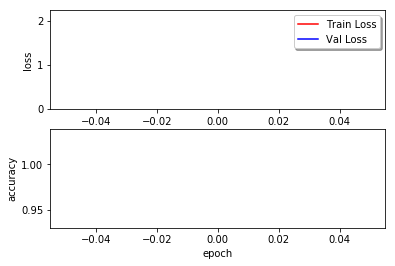

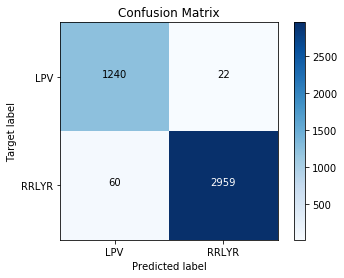

EPOCH: 2
TRAIN LOSS: 0.07025440933495028
VAL LOSS: 0.07490658202065917
VAL ACCURACY: 98.9 %
TIME: 57.7 s


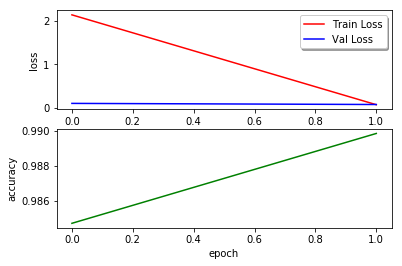

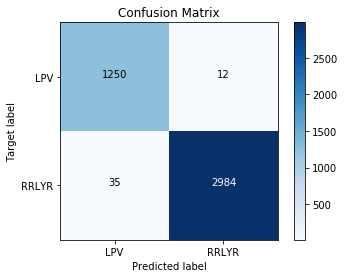

EPOCH: 3
TRAIN LOSS: 0.032680584710630324
VAL LOSS: 0.042905680004199254
VAL ACCURACY: 99.2 %
TIME: 57.7 s


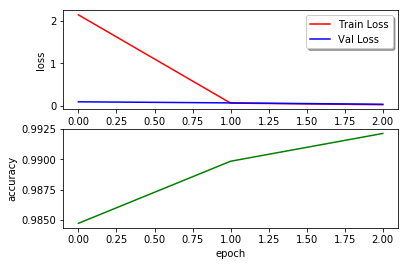

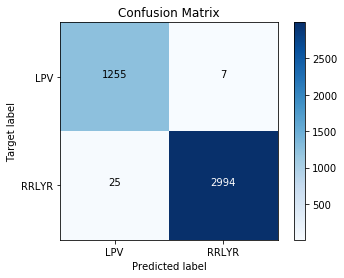

EPOCH: 4
TRAIN LOSS: 0.02223762346753293
VAL LOSS: 0.025805630082782784
VAL ACCURACY: 99.3 %
TIME: 57.3 s


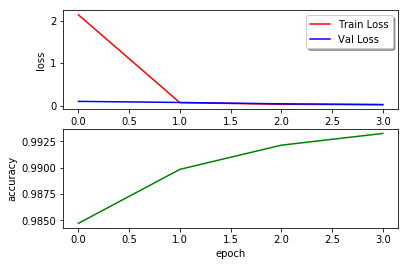

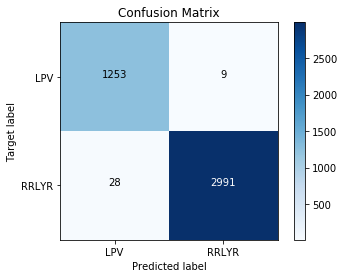

EPOCH: 5
TRAIN LOSS: 0.024951795068037116
VAL LOSS: 0.013154512707055343
VAL ACCURACY: 99.4 %
TIME: 56.5 s


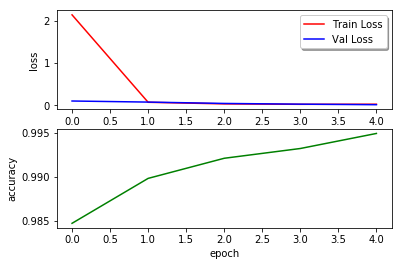

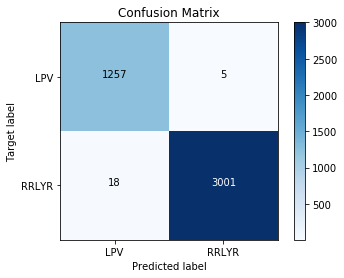

EPOCH: 6
TRAIN LOSS: 0.01780019910849405
VAL LOSS: 0.023298949732304945
VAL ACCURACY: 99.4 %
TIME: 56.3 s


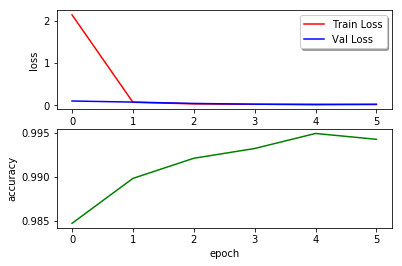

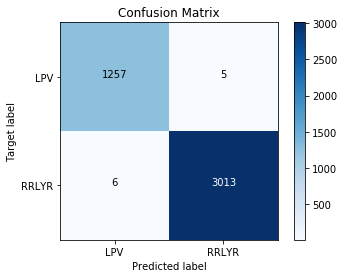

EPOCH: 7
TRAIN LOSS: 0.014122244138685236
VAL LOSS: 0.015811868947544064
VAL ACCURACY: 99.4 %
TIME: 56.7 s


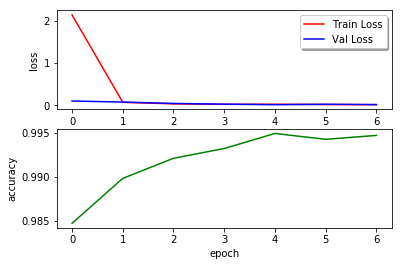

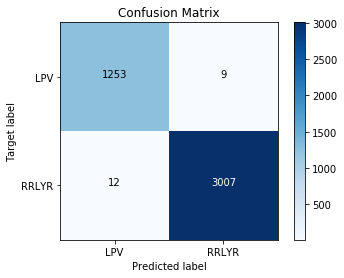

EPOCH: 8
TRAIN LOSS: 0.011541517217224816
VAL LOSS: 0.023934153378704234
VAL ACCURACY: 99.4 %
TIME: 58.0 s


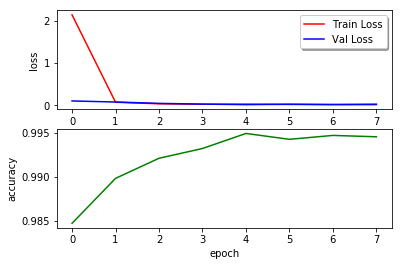

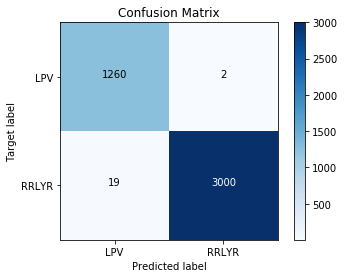

EPOCH: 9
TRAIN LOSS: 0.010234683959527717
VAL LOSS: 0.011153771149948406
VAL ACCURACY: 99.6 %
TIME: 59.2 s


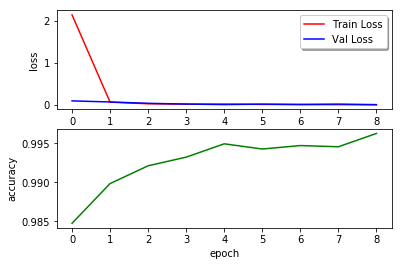

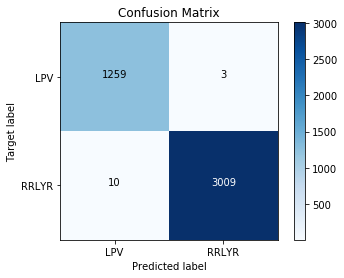

EPOCH: 10
TRAIN LOSS: 0.007969227524903049
VAL LOSS: 0.006441333755851592
VAL ACCURACY: 99.8 %
TIME: 60.4 s


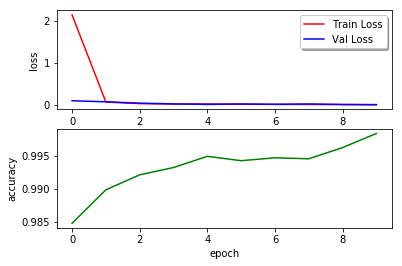

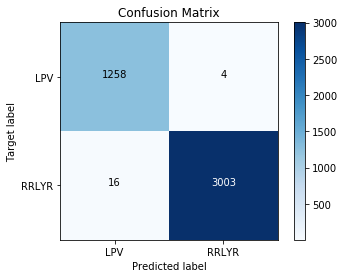

EPOCH: 11
TRAIN LOSS: 0.008053360437869427
VAL LOSS: 0.011916220878212
VAL ACCURACY: 99.4 %
TIME: 57.2 s


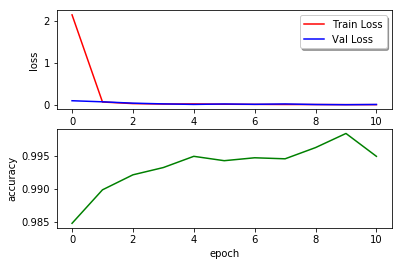

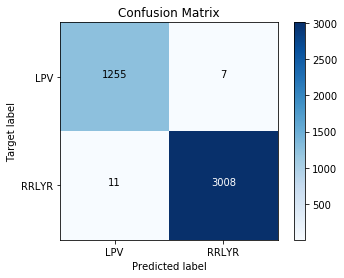

EPOCH: 12
TRAIN LOSS: 0.008156126584766303
VAL LOSS: 0.010700747868475875
VAL ACCURACY: 99.7 %
TIME: 56.6 s


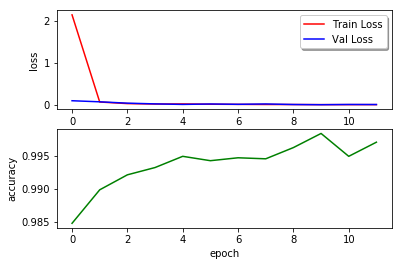

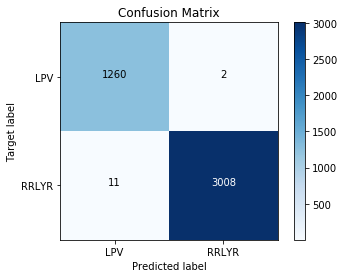

EPOCH: 13
TRAIN LOSS: 0.007186191228479415
VAL LOSS: 0.007865864513439617
VAL ACCURACY: 99.6 %
TIME: 56.6 s


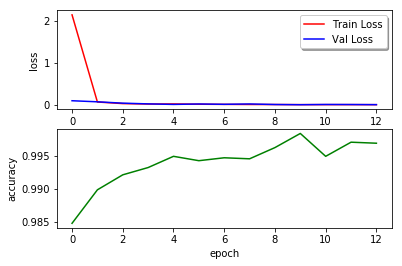

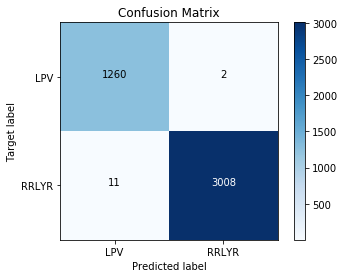

EPOCH: 14
TRAIN LOSS: 0.007420305913633589
VAL LOSS: 0.014942268695016015
VAL ACCURACY: 99.5 %
TIME: 56.5 s


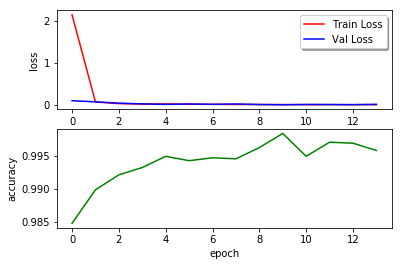

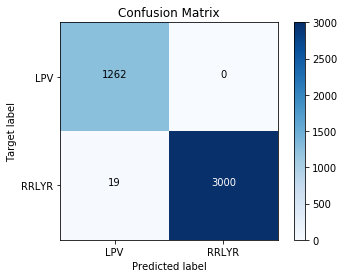

EPOCH: 15
TRAIN LOSS: 0.005792982560222552
VAL LOSS: 0.008282038304660611
VAL ACCURACY: 99.7 %
TIME: 57.1 s


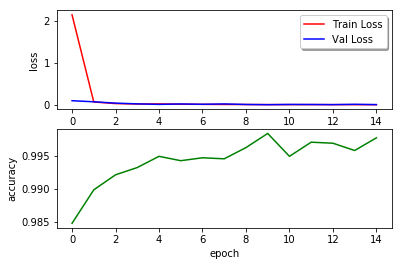

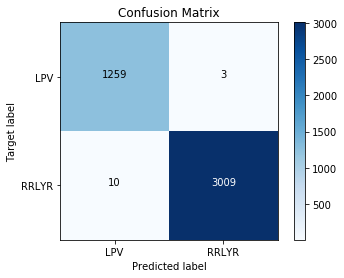

EPOCH: 16
TRAIN LOSS: 0.004869341780304153
VAL LOSS: 0.0046490363192927065
VAL ACCURACY: 99.8 %
TIME: 56.7 s


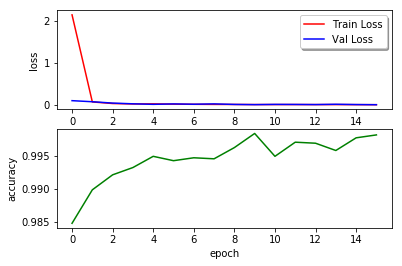

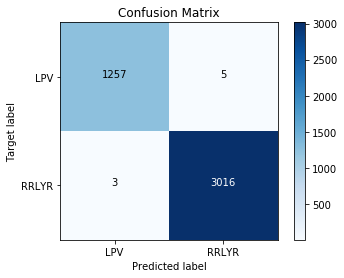

EPOCH: 17
TRAIN LOSS: 0.005622970297279361
VAL LOSS: 0.019287195782258827
VAL ACCURACY: 99.4 %
TIME: 56.9 s


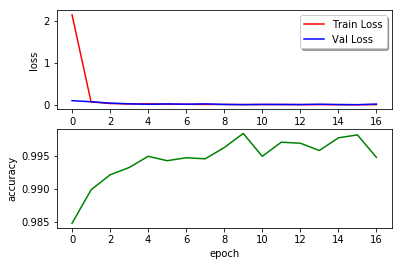

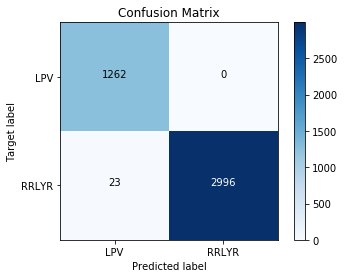

EPOCH: 18
TRAIN LOSS: 0.0059466078066417296
VAL LOSS: 0.004040979569159398
VAL ACCURACY: 99.8 %
TIME: 56.5 s


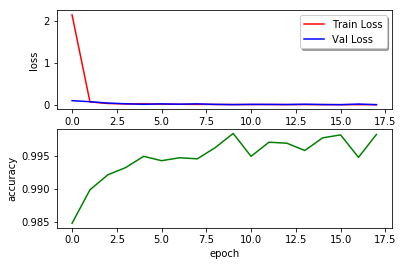

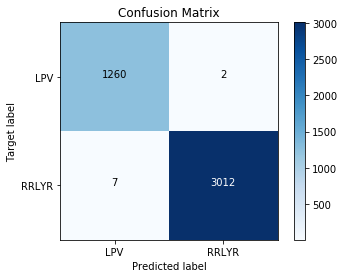

EPOCH: 19
TRAIN LOSS: 0.0038727199498699177
VAL LOSS: 0.0049328501934898
VAL ACCURACY: 99.8 %
TIME: 56.4 s


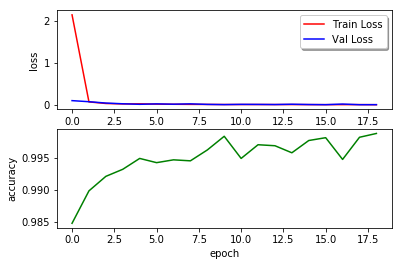

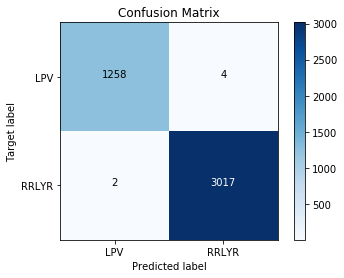

EPOCH: 20
TRAIN LOSS: 0.00402338250379552
VAL LOSS: 0.009674245319383943
VAL ACCURACY: 99.6 %
TIME: 56.5 s


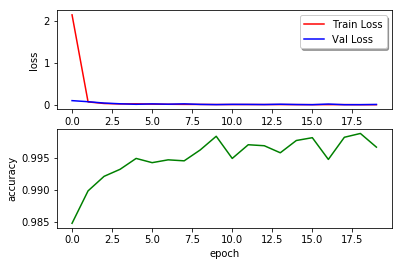

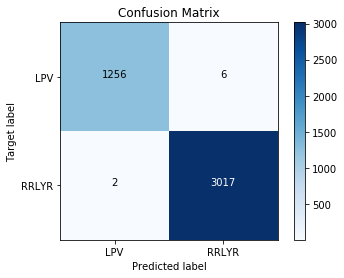

EPOCH: 21
TRAIN LOSS: 0.0023862222039465466
VAL LOSS: 0.004465035036112506
VAL ACCURACY: 99.8 %
TIME: 57.0 s


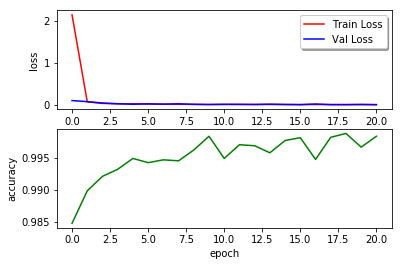

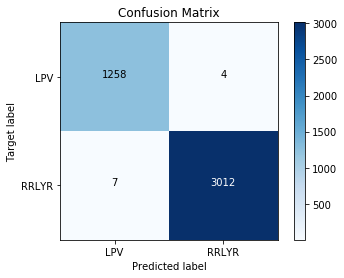

EPOCH: 22
TRAIN LOSS: 0.003614379566208848
VAL LOSS: 0.009053352005170495
VAL ACCURACY: 99.8 %
TIME: 56.2 s


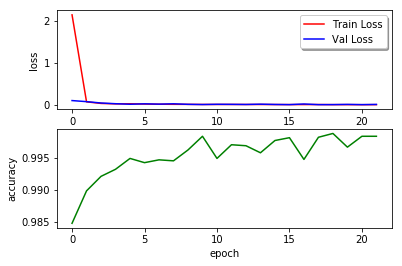

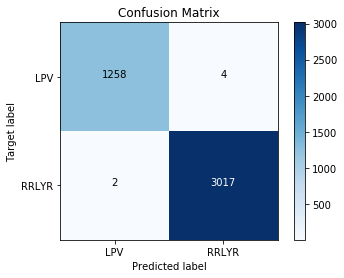

EPOCH: 23
TRAIN LOSS: 0.002440771911130731
VAL LOSS: 0.006402908700209252
VAL ACCURACY: 99.8 %
TIME: 56.2 s


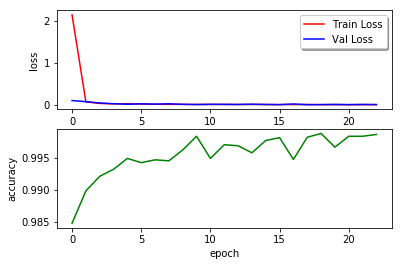

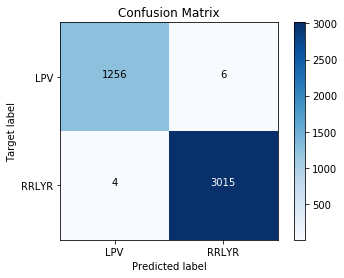

EPOCH: 24
TRAIN LOSS: 0.0010988734695801573
VAL LOSS: 0.006412625765949169
VAL ACCURACY: 99.9 %
TIME: 56.3 s


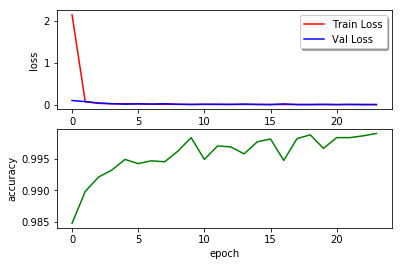

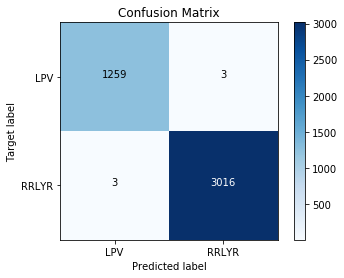

EPOCH: 25
TRAIN LOSS: 0.001960519883232921
VAL LOSS: 0.008064153254417531
VAL ACCURACY: 99.7 %
TIME: 56.6 s


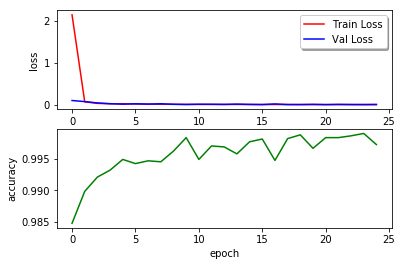

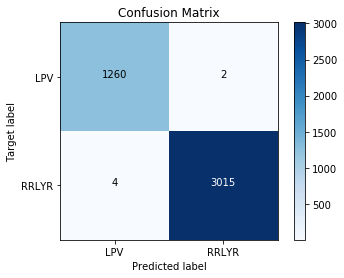

EPOCH: 26
TRAIN LOSS: 0.002428903954942424
VAL LOSS: 0.004615761754221117
VAL ACCURACY: 99.8 %
TIME: 56.3 s


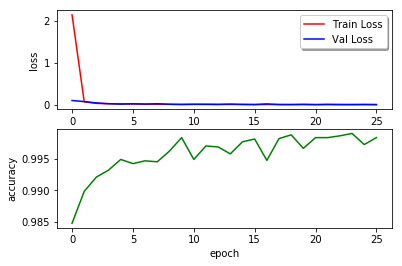

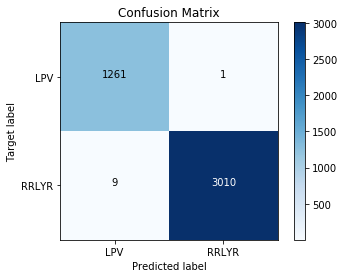

EPOCH: 27
TRAIN LOSS: 0.0023992378841558824
VAL LOSS: 0.009174605628690765
VAL ACCURACY: 99.8 %
TIME: 56.4 s


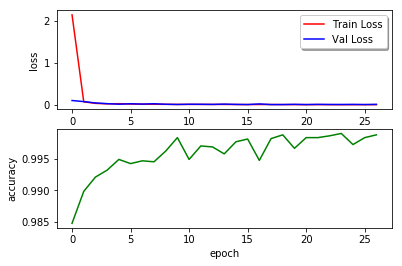

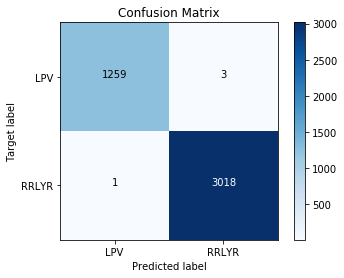

EPOCH: 28
TRAIN LOSS: 0.0018671599984057812
VAL LOSS: 0.0054376619848618924
VAL ACCURACY: 99.9 %
TIME: 56.7 s


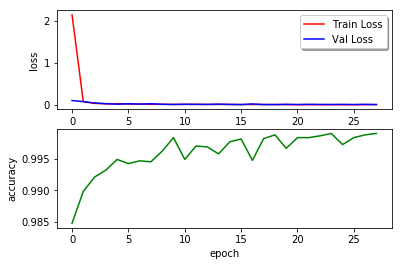

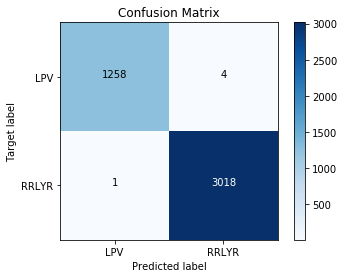

EPOCH: 29
TRAIN LOSS: 0.0029699386438868814
VAL LOSS: 0.005335419339506586
VAL ACCURACY: 99.8 %
TIME: 56.2 s


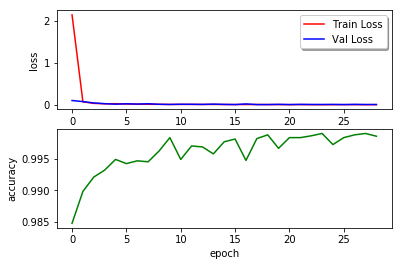

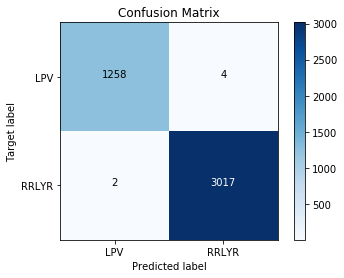

EPOCH: 30
TRAIN LOSS: 0.0015900579422376473
VAL LOSS: 0.011069969069911421
VAL ACCURACY: 99.8 %
TIME: 56.3 s


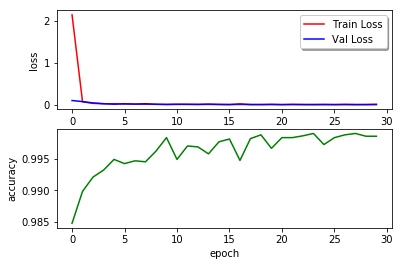

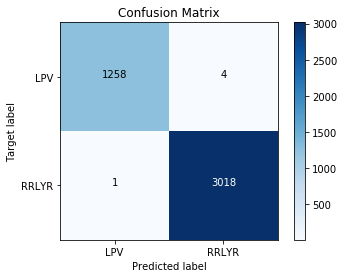

EPOCH: 31
TRAIN LOSS: 0.0019755596949825333
VAL LOSS: 0.01136603188409489
VAL ACCURACY: 99.7 %
TIME: 56.3 s


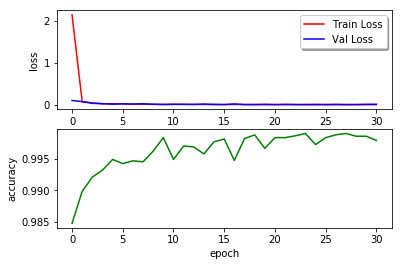

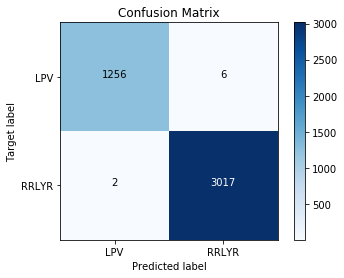

EPOCH: 32
TRAIN LOSS: 0.002814624080372872
VAL LOSS: 0.009852399399113723
VAL ACCURACY: 99.8 %
TIME: 56.7 s


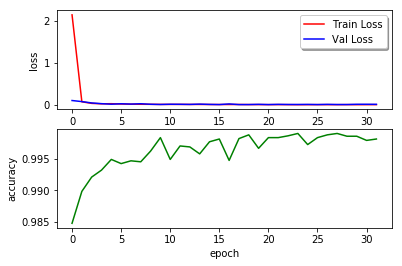

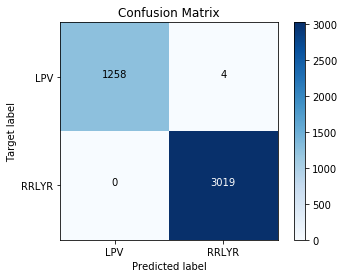

EPOCH: 33
TRAIN LOSS: 0.002527487480261993
VAL LOSS: 0.010383232254368529
VAL ACCURACY: 99.9 %
TIME: 57.1 s


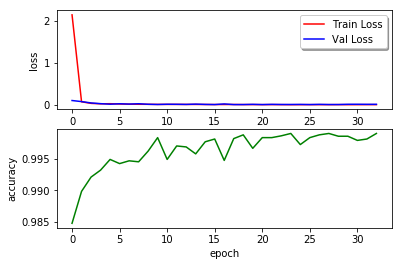

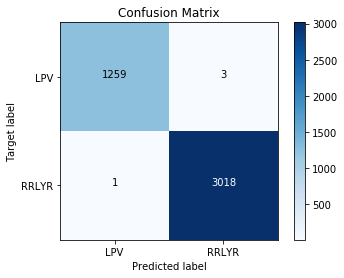

EPOCH: 34
TRAIN LOSS: 0.0021192706854038573
VAL LOSS: 0.010783902052098813
VAL ACCURACY: 99.7 %
TIME: 57.7 s


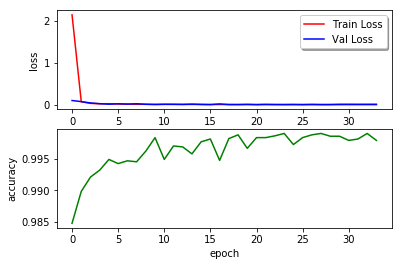

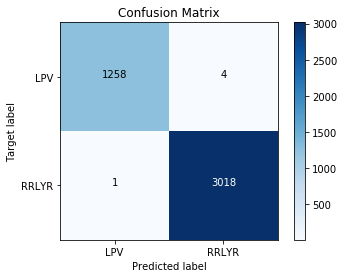

EPOCH: 35
TRAIN LOSS: 0.0009915789330994626
VAL LOSS: 0.009485087007017532
VAL ACCURACY: 99.8 %
TIME: 56.6 s


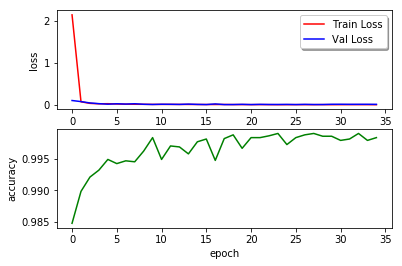

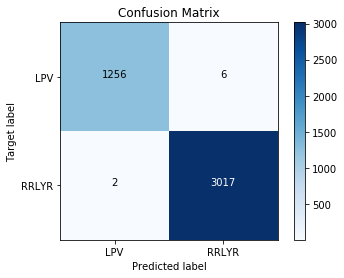

EPOCH: 36
TRAIN LOSS: 0.0005898807196653992
VAL LOSS: 0.008073273460231144
VAL ACCURACY: 99.8 %
TIME: 56.5 s


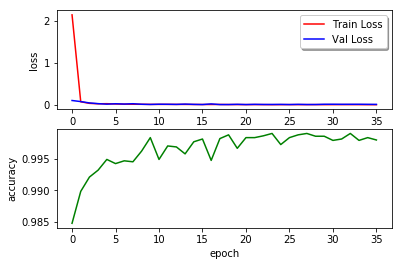

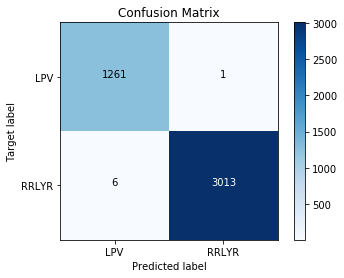

EPOCH: 37
TRAIN LOSS: 0.0013369171627383067
VAL LOSS: 0.008771773294188202
VAL ACCURACY: 99.8 %
TIME: 56.4 s


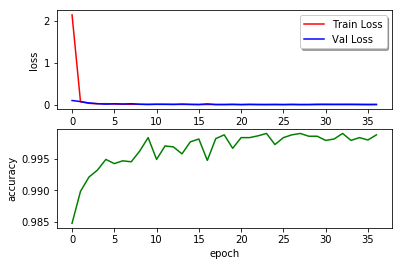

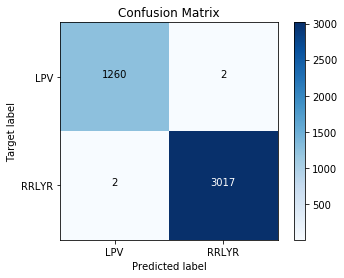

EPOCH: 38
TRAIN LOSS: 0.0017032053055207057
VAL LOSS: 0.005157077582966691
VAL ACCURACY: 99.8 %
TIME: 56.4 s


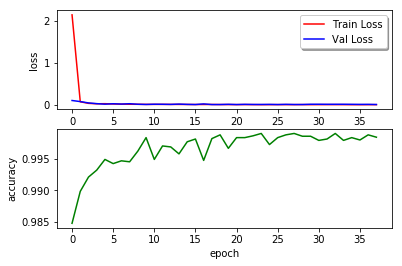

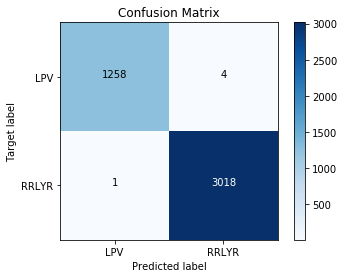

EPOCH: 39
TRAIN LOSS: 0.0008406832839371118
VAL LOSS: 0.005053390483679615
VAL ACCURACY: 99.9 %
TIME: 56.4 s


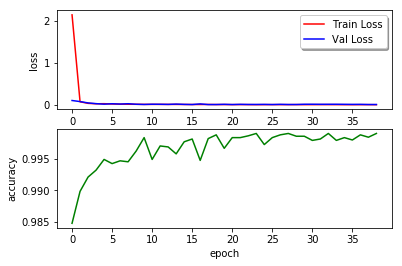

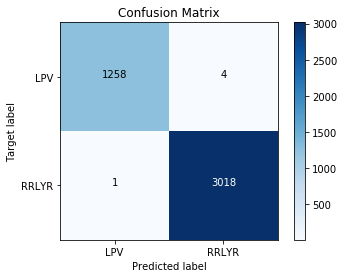

EPOCH: 40
TRAIN LOSS: 0.0013476151606203182
VAL LOSS: 0.008529059113366223
VAL ACCURACY: 99.8 %
TIME: 56.5 s


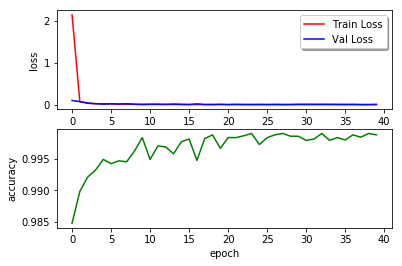

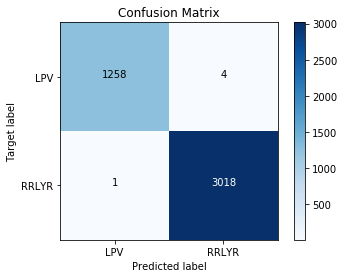

EPOCH: 41
TRAIN LOSS: 0.0005908525648845995
VAL LOSS: 0.007450042581545632
VAL ACCURACY: 99.8 %
TIME: 56.4 s


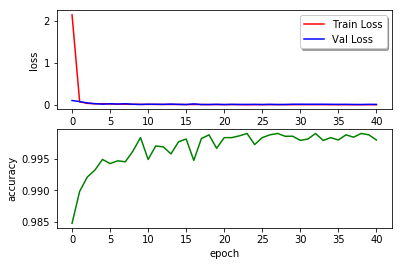

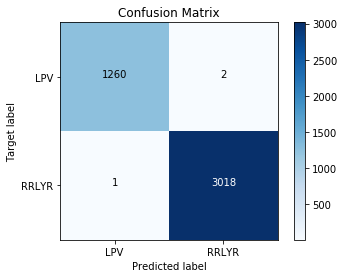

EPOCH: 42
TRAIN LOSS: 0.0011890096706151955
VAL LOSS: 0.010643590374552337
VAL ACCURACY: 99.9 %
TIME: 56.5 s


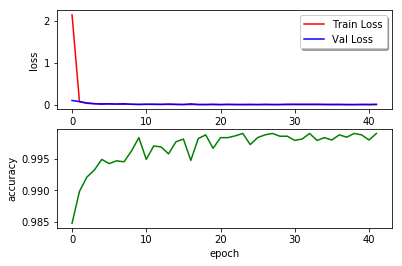

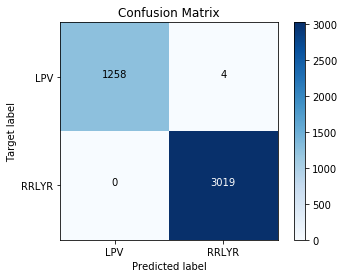

EPOCH: 43
TRAIN LOSS: 0.0013986818699222294
VAL LOSS: 0.008341143695021664
VAL ACCURACY: 99.8 %
TIME: 56.4 s


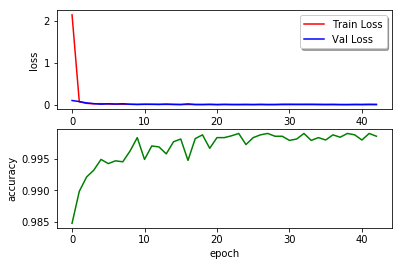

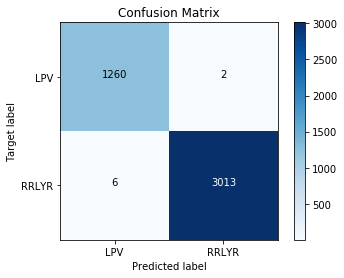

EPOCH: 44
TRAIN LOSS: 0.001836942821046039
VAL LOSS: 0.010086299444608933
VAL ACCURACY: 99.8 %
TIME: 56.6 s


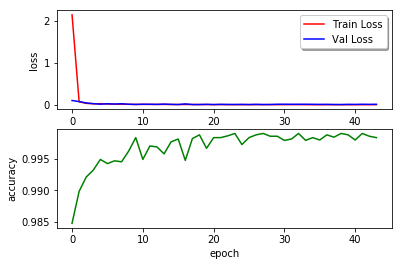

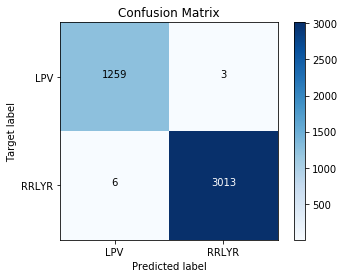

EPOCH: 45
TRAIN LOSS: 0.0033912710488870354
VAL LOSS: 0.018534578713207985
VAL ACCURACY: 99.7 %
TIME: 56.6 s


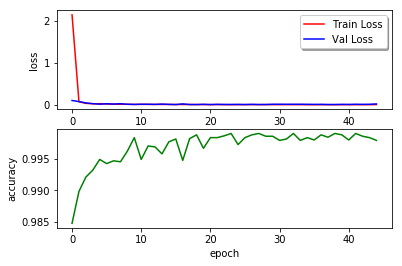

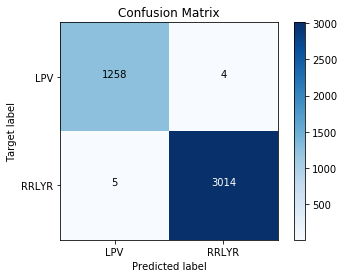

EPOCH: 46
TRAIN LOSS: 0.004282064690175204
VAL LOSS: 0.013681611170690963
VAL ACCURACY: 99.8 %
TIME: 56.6 s


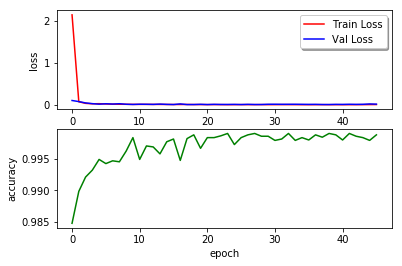

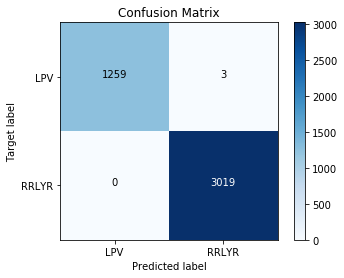

EPOCH: 47
TRAIN LOSS: 0.003735506318992024
VAL LOSS: 0.01102594494181506
VAL ACCURACY: 99.8 %
TIME: 56.6 s


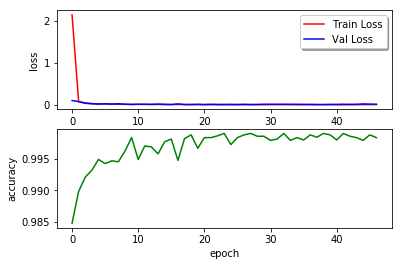

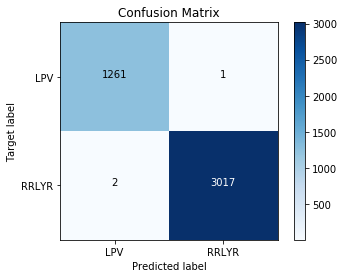

EPOCH: 48
TRAIN LOSS: 0.0037804145805535607
VAL LOSS: 0.02111804821010297
VAL ACCURACY: 99.4 %
TIME: 56.6 s


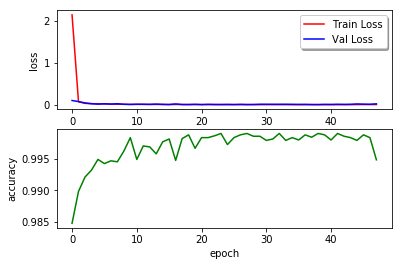

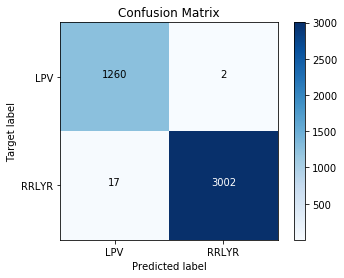

EPOCH: 49
TRAIN LOSS: 0.0017128886168766668
VAL LOSS: 0.008543282242127593
VAL ACCURACY: 99.8 %
TIME: 56.6 s


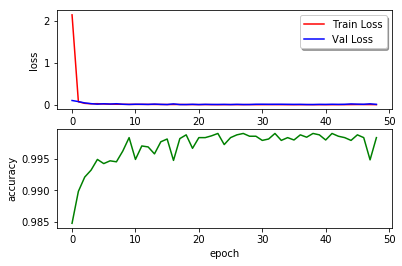

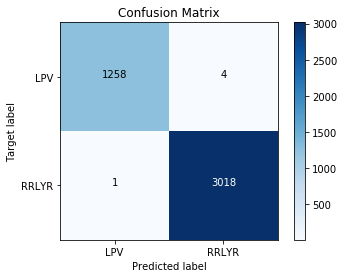

EPOCH: 50
TRAIN LOSS: 0.0018988441847953954
VAL LOSS: 0.008746171605537586
VAL ACCURACY: 99.7 %
TIME: 56.5 s


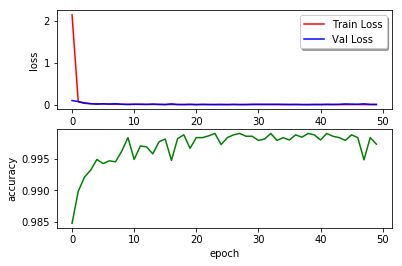

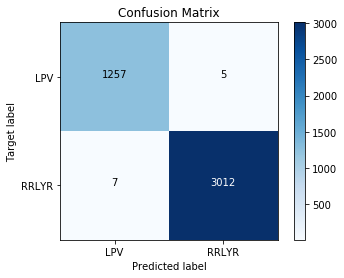

EPOCH: 51
TRAIN LOSS: 0.002880640323219317
VAL LOSS: 0.006177482145623602
VAL ACCURACY: 99.8 %
TIME: 56.5 s


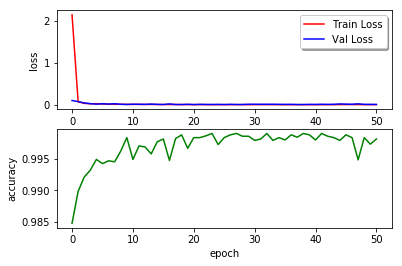

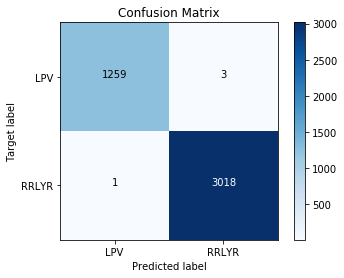

EPOCH: 52
TRAIN LOSS: 0.0016838894607526208
VAL LOSS: 0.004164369690589432
VAL ACCURACY: 99.8 %
TIME: 56.8 s


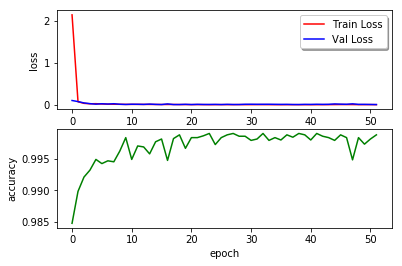

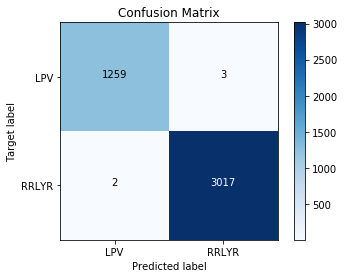

EPOCH: 53
TRAIN LOSS: 0.0013998424435043625
VAL LOSS: 0.00795138258608203
VAL ACCURACY: 99.8 %
TIME: 56.4 s


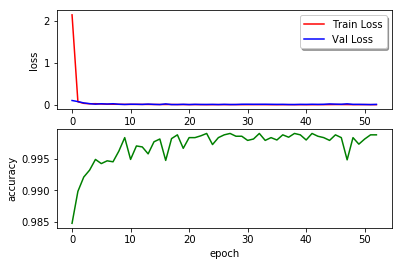

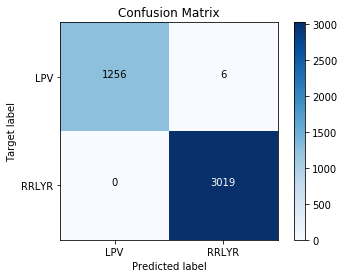

EPOCH: 54
TRAIN LOSS: 0.0020292375003175566
VAL LOSS: 0.0067372286511537625
VAL ACCURACY: 99.8 %
TIME: 56.5 s


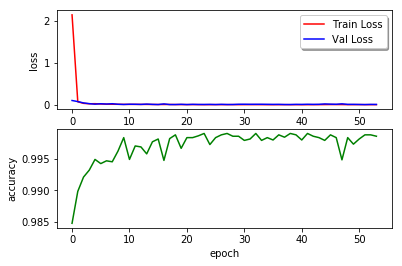

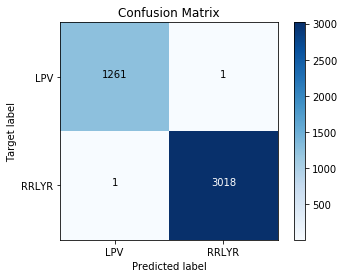

EPOCH: 55
TRAIN LOSS: 0.0025735343223485994
VAL LOSS: 0.01102301714858842
VAL ACCURACY: 99.7 %
TIME: 56.5 s


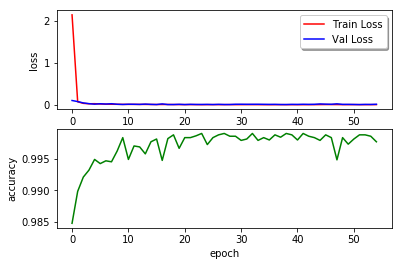

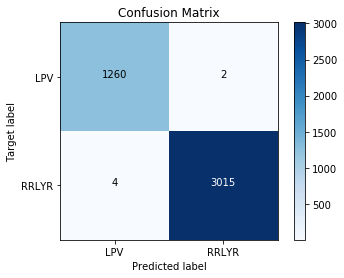

EPOCH: 56
TRAIN LOSS: 0.0015754154286786437
VAL LOSS: 0.00855800610005785
VAL ACCURACY: 99.9 %
TIME: 56.4 s


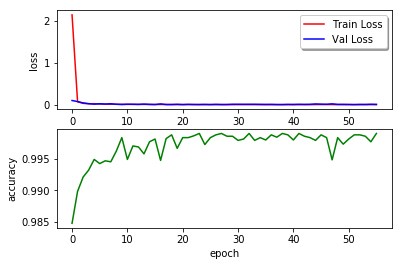

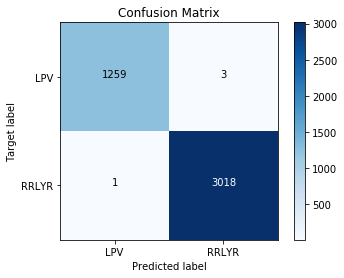

EPOCH: 57
TRAIN LOSS: 0.0029668141318547263
VAL LOSS: 0.014757098790661465
VAL ACCURACY: 99.7 %
TIME: 56.4 s


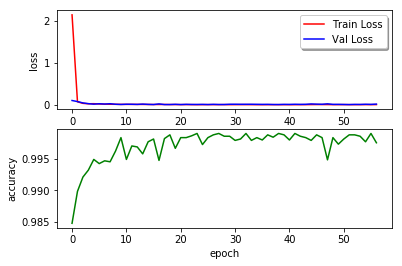

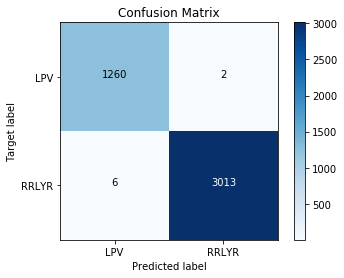

EPOCH: 58
TRAIN LOSS: 0.003197450819379255
VAL LOSS: 0.007049419003356824
VAL ACCURACY: 99.7 %
TIME: 56.3 s


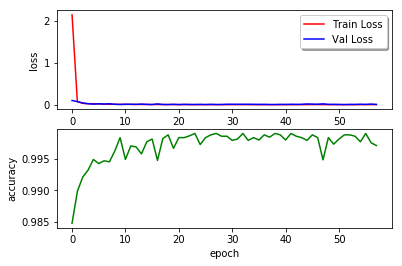

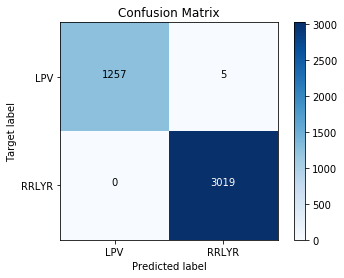

EPOCH: 59
TRAIN LOSS: 0.001765500675255112
VAL LOSS: 0.008692489982803654
VAL ACCURACY: 99.8 %
TIME: 56.3 s


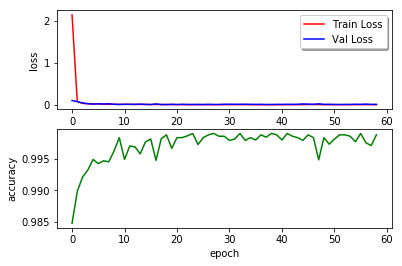

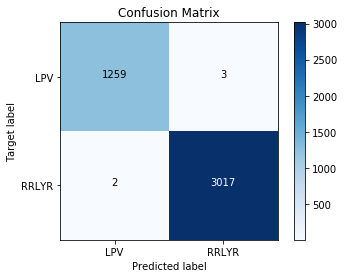

EPOCH: 60
TRAIN LOSS: 0.0010277777439491416
VAL LOSS: 0.008012320139106624
VAL ACCURACY: 99.8 %
TIME: 56.3 s


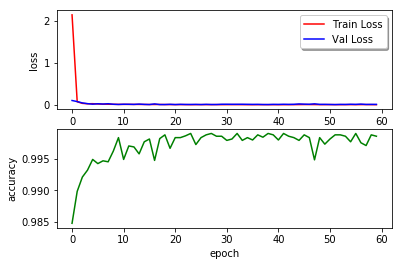

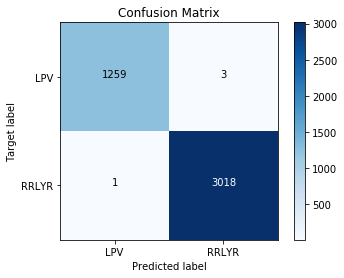

EPOCH: 61
TRAIN LOSS: 0.00021546836983120686
VAL LOSS: 0.005018816981361399
VAL ACCURACY: 99.9 %
TIME: 56.4 s


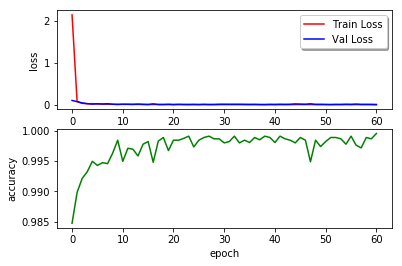

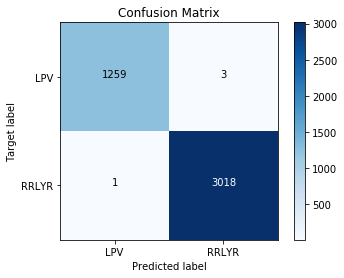

EPOCH: 62
TRAIN LOSS: 0.0013876329975523235
VAL LOSS: 0.008576848377476548
VAL ACCURACY: 99.7 %
TIME: 56.4 s


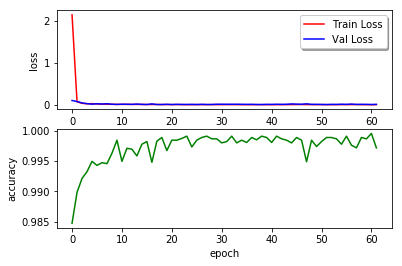

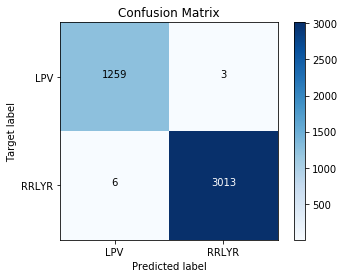

EPOCH: 63
TRAIN LOSS: 0.0014069569296961408
VAL LOSS: 0.015757901524936016
VAL ACCURACY: 99.8 %
TIME: 56.4 s


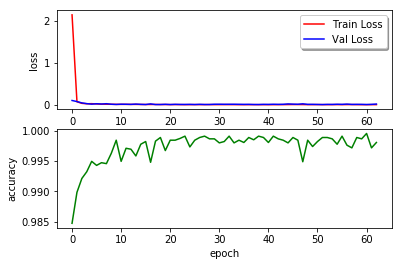

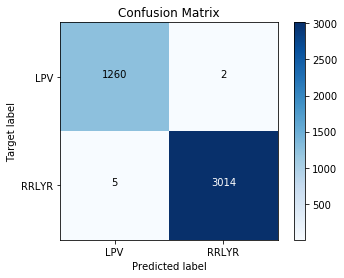

EPOCH: 64
TRAIN LOSS: 0.00038897289890867646
VAL LOSS: 0.00983535425191376
VAL ACCURACY: 99.8 %
TIME: 56.4 s


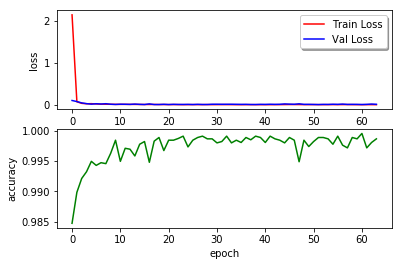

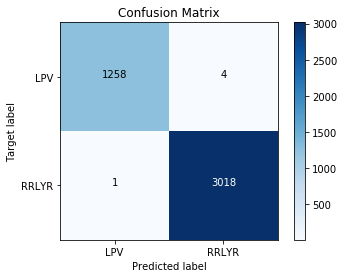

EPOCH: 65
TRAIN LOSS: 0.0010330954207523957
VAL LOSS: 0.008632081369426151
VAL ACCURACY: 99.8 %
TIME: 56.6 s


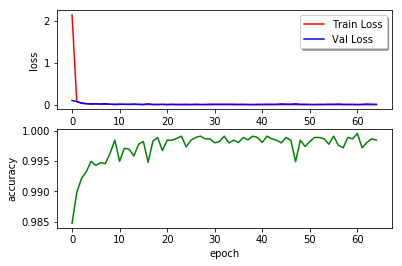

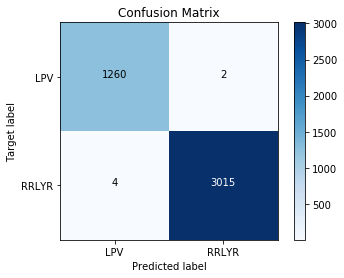

EPOCH: 66
TRAIN LOSS: 0.0013403864615966134
VAL LOSS: 0.004699127747617067
VAL ACCURACY: 99.9 %
TIME: 56.3 s


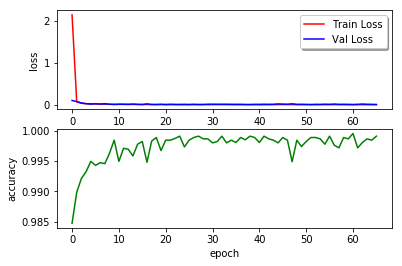

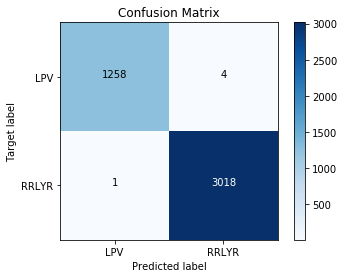

EPOCH: 67
TRAIN LOSS: 0.0004852394145368274
VAL LOSS: 0.005581977650267964
VAL ACCURACY: 99.9 %
TIME: 56.4 s


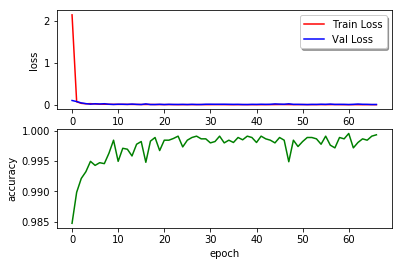

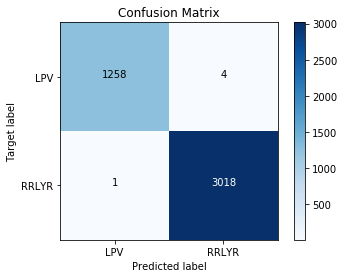

EPOCH: 68
TRAIN LOSS: 0.0014460088307187752
VAL LOSS: 0.007990240796616725
VAL ACCURACY: 99.8 %
TIME: 56.3 s


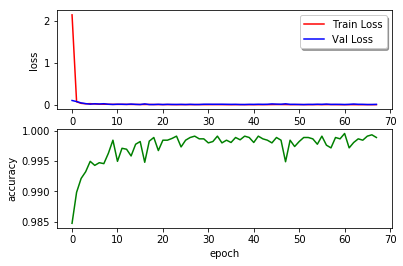

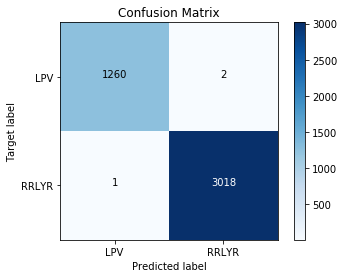

EPOCH: 69
TRAIN LOSS: 0.0008928090847801831
VAL LOSS: 0.013336432187980033
VAL ACCURACY: 99.7 %
TIME: 56.4 s


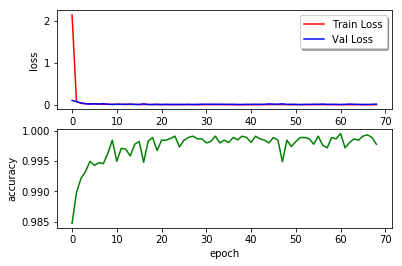

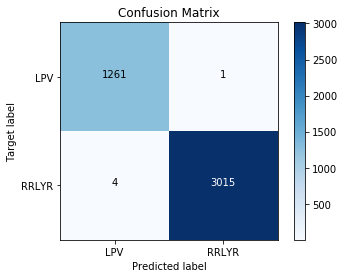

EPOCH: 70
TRAIN LOSS: 0.002209610126307785
VAL LOSS: 0.009389420697349537
VAL ACCURACY: 99.8 %
TIME: 56.6 s


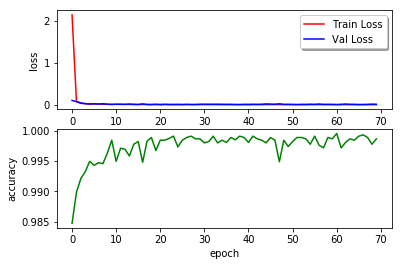

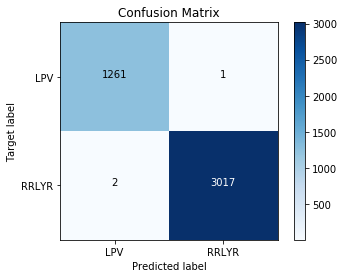

EPOCH: 71
TRAIN LOSS: 0.0028401082805029902
VAL LOSS: 0.011802669199515914
VAL ACCURACY: 99.7 %
TIME: 56.5 s


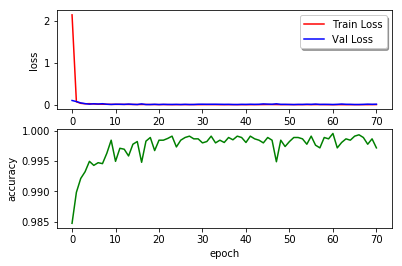

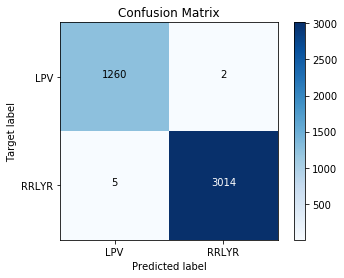

EPOCH: 72
TRAIN LOSS: 0.005090314539192741
VAL LOSS: 0.01270053816592807
VAL ACCURACY: 99.9 %
TIME: 56.6 s


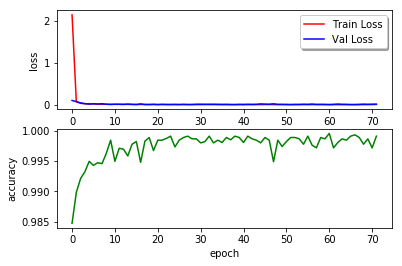

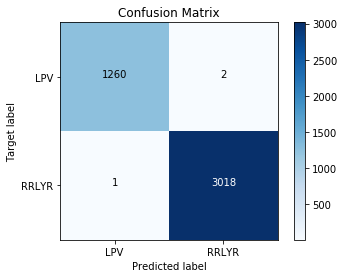

EPOCH: 73
TRAIN LOSS: 0.0010516369211833688
VAL LOSS: 0.007128604706473771
VAL ACCURACY: 99.9 %
TIME: 56.4 s


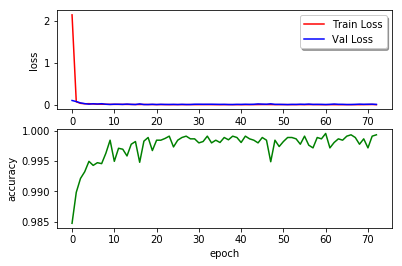

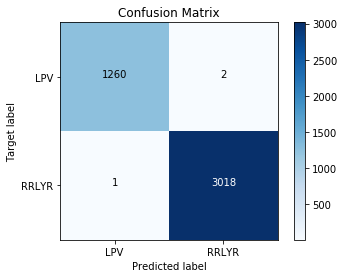

EPOCH: 74
TRAIN LOSS: 0.0008040882332431784
VAL LOSS: 0.007736621225099799
VAL ACCURACY: 99.9 %
TIME: 56.4 s


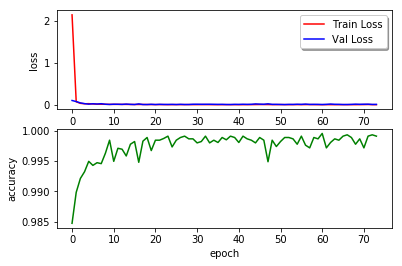

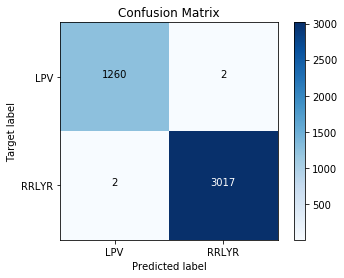

EPOCH: 75
TRAIN LOSS: 0.0008273183411516194
VAL LOSS: 0.0077702531780598095
VAL ACCURACY: 99.9 %
TIME: 56.2 s


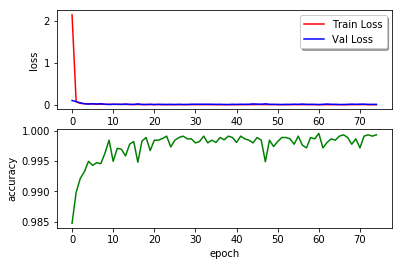

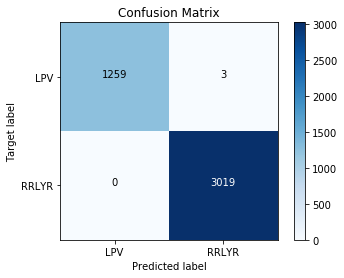

EPOCH: 76
TRAIN LOSS: 0.00010711410187019857
VAL LOSS: 0.005139037652455571
VAL ACCURACY: 99.9 %
TIME: 56.2 s


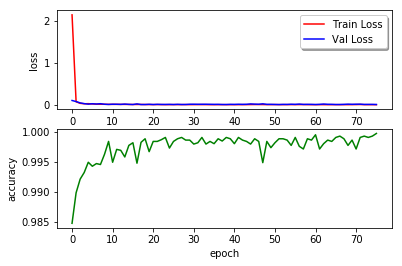

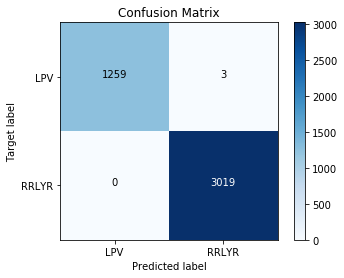

EPOCH: 77
TRAIN LOSS: 0.0002187861455457402
VAL LOSS: 0.0036902331380596638
VAL ACCURACY: 99.9 %
TIME: 56.5 s


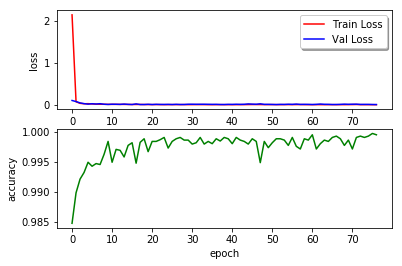

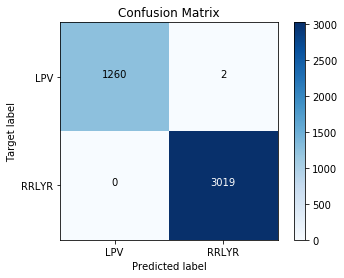

EPOCH: 78
TRAIN LOSS: 0.00035803407517087996
VAL LOSS: 0.013983796860976817
VAL ACCURACY: 99.9 %
TIME: 56.6 s


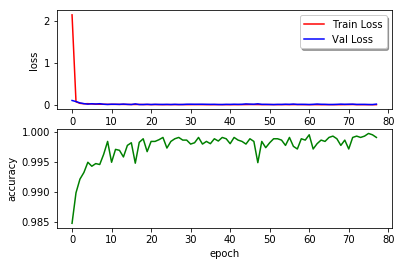

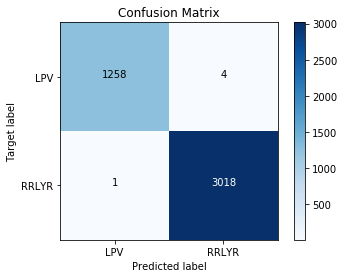

EPOCH: 79
TRAIN LOSS: 0.0007230052218816087
VAL LOSS: 0.014233596484251688
VAL ACCURACY: 99.9 %
TIME: 56.6 s


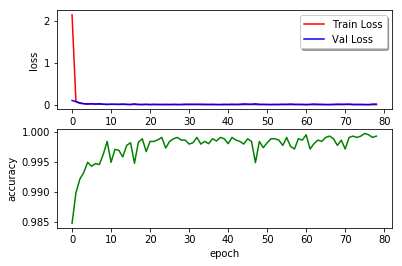

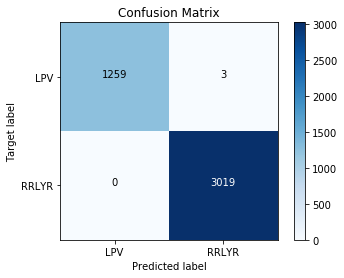

EPOCH: 80
TRAIN LOSS: 0.00042004906918706686
VAL LOSS: 0.008756521292588021
VAL ACCURACY: 99.9 %
TIME: 58.0 s


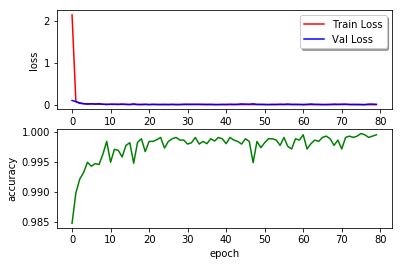

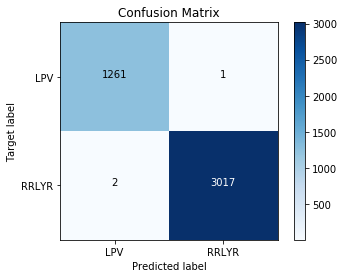

EPOCH: 81
TRAIN LOSS: 0.0004456924232838974
VAL LOSS: 0.0155184636087643
VAL ACCURACY: 99.8 %
TIME: 56.6 s


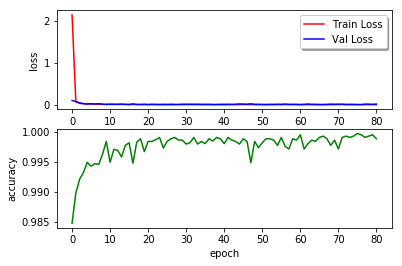

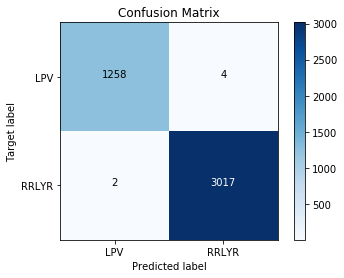

EPOCH: 82
TRAIN LOSS: 9.84340508842769e-05
VAL LOSS: 0.012143085263367687
VAL ACCURACY: 99.9 %
TIME: 59.5 s


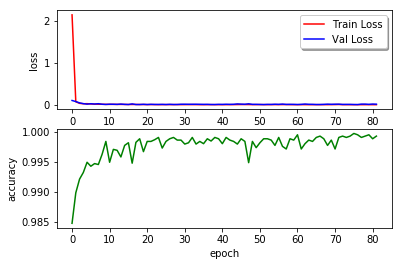

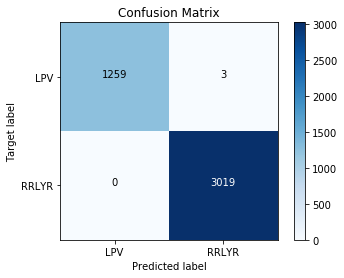

EPOCH: 83
TRAIN LOSS: 0.0003170473138374081
VAL LOSS: 0.009011645913818003
VAL ACCURACY: 99.9 %
TIME: 63.9 s


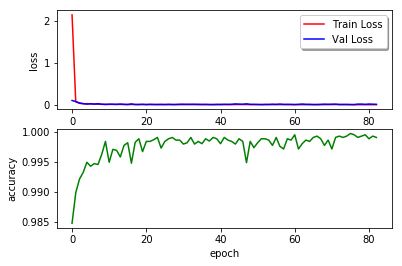

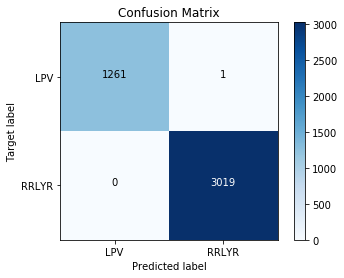

EPOCH: 84
TRAIN LOSS: 0.0003565928586874188
VAL LOSS: 0.008578902982193314
VAL ACCURACY: 99.9 %
TIME: 65.6 s


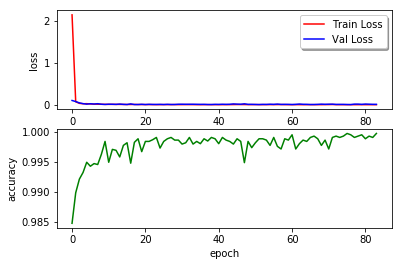

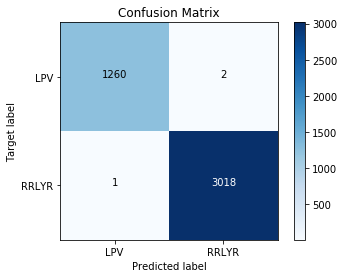

EPOCH: 85
TRAIN LOSS: 0.0006606654409182663
VAL LOSS: 0.00863263594278099
VAL ACCURACY: 99.9 %
TIME: 65.8 s


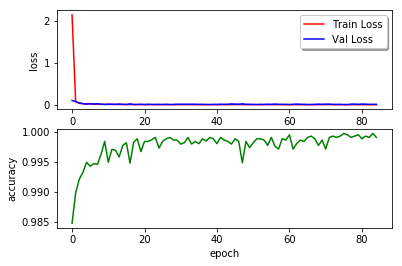

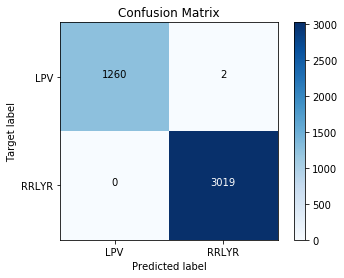

EPOCH: 86
TRAIN LOSS: 0.00037784076068404077
VAL LOSS: 0.010362393371280086
VAL ACCURACY: 99.8 %
TIME: 65.1 s


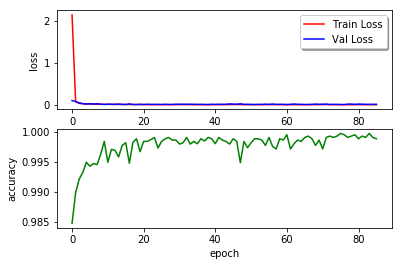

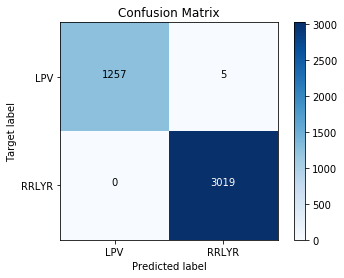

EPOCH: 87
TRAIN LOSS: 6.714977957002713e-05
VAL LOSS: 0.01074873319934453
VAL ACCURACY: 99.9 %
TIME: 62.6 s


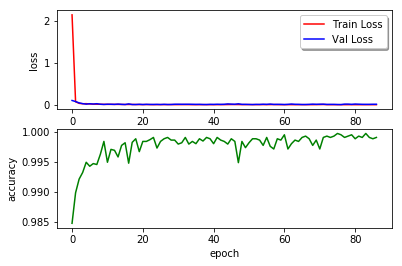

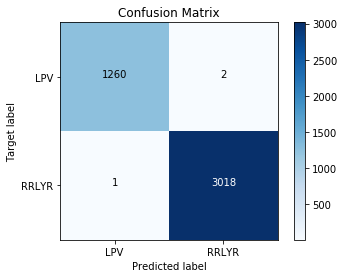

EPOCH: 88
TRAIN LOSS: 0.00041903447154432343
VAL LOSS: 0.010957131414388886
VAL ACCURACY: 99.9 %
TIME: 62.8 s


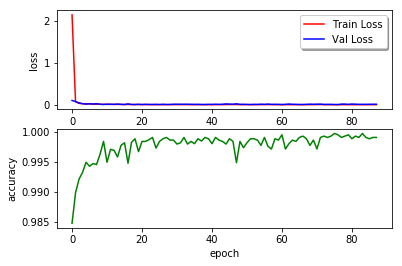

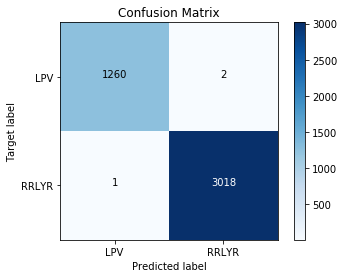

EPOCH: 89
TRAIN LOSS: 0.0001374462010379483
VAL LOSS: 0.014879657748990424
VAL ACCURACY: 99.8 %
TIME: 62.3 s


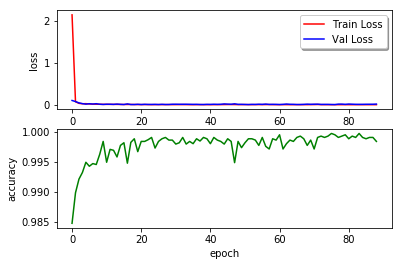

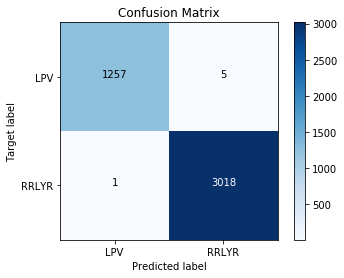

EPOCH: 90
TRAIN LOSS: 0.0021537829496766562
VAL LOSS: 0.0163082176666945
VAL ACCURACY: 99.8 %
TIME: 62.2 s


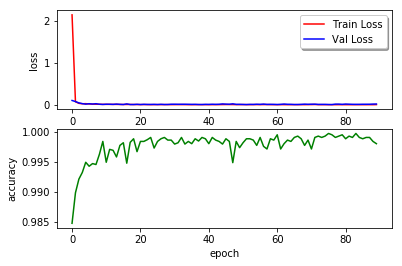

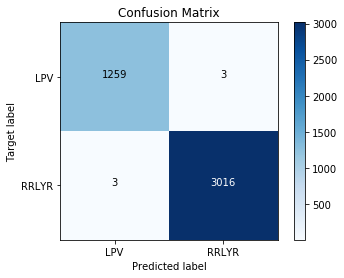

EPOCH: 91
TRAIN LOSS: 0.0016278524942406993
VAL LOSS: 0.009992784803523001
VAL ACCURACY: 99.8 %
TIME: 62.7 s


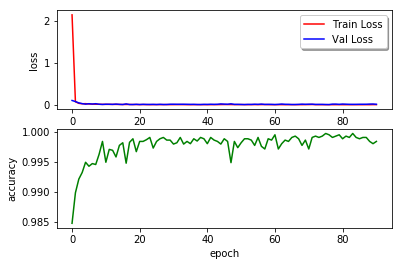

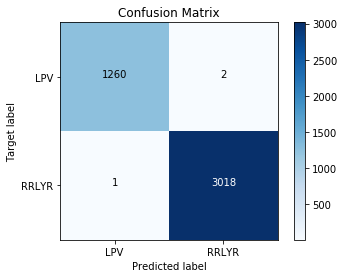

EPOCH: 92
TRAIN LOSS: 0.0007006038762663798
VAL LOSS: 0.016197260887047885
VAL ACCURACY: 99.8 %
TIME: 62.8 s


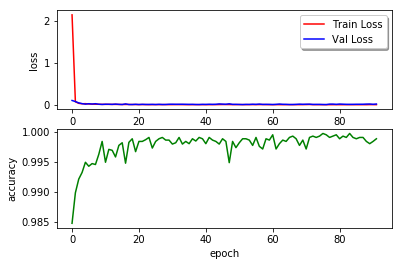

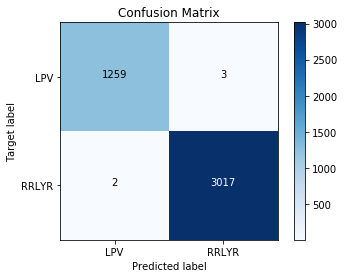

EPOCH: 93
TRAIN LOSS: 0.000422084044574624
VAL LOSS: 0.013139939808340358
VAL ACCURACY: 99.9 %
TIME: 62.5 s


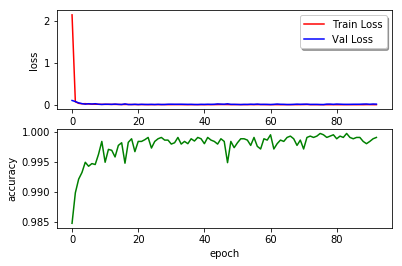

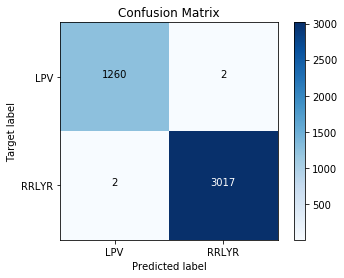

EPOCH: 94
TRAIN LOSS: 7.906168182658301e-05
VAL LOSS: 0.012066067881636187
VAL ACCURACY: 99.8 %
TIME: 62.1 s


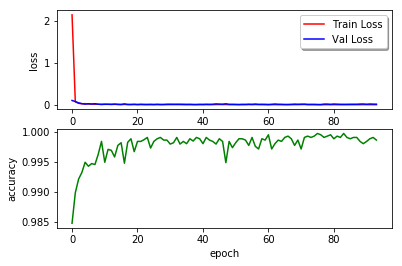

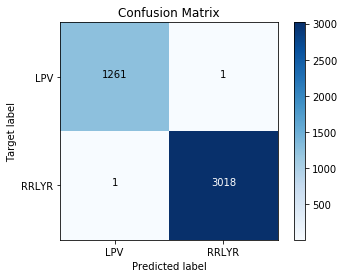

EPOCH: 95
TRAIN LOSS: 0.0004709144490832009
VAL LOSS: 0.01490814192111942
VAL ACCURACY: 99.9 %
TIME: 62.2 s


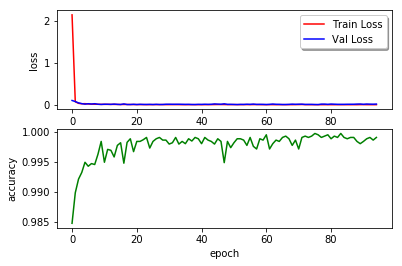

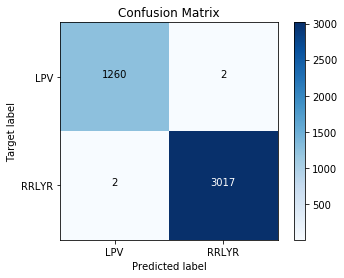

EPOCH: 96
TRAIN LOSS: 0.000647691240943786
VAL LOSS: 0.012011635918802067
VAL ACCURACY: 99.9 %
TIME: 62.5 s


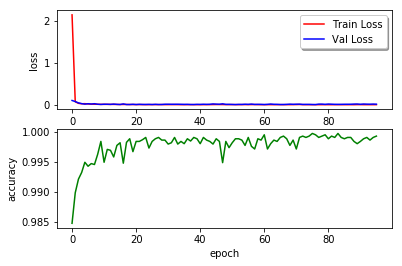

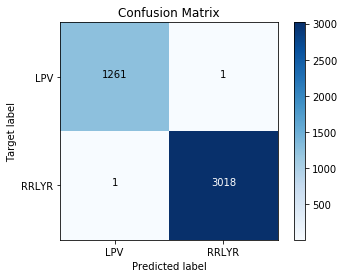

EPOCH: 97
TRAIN LOSS: 0.00039018596497730496
VAL LOSS: 0.01739497540241885
VAL ACCURACY: 99.9 %
TIME: 63.0 s


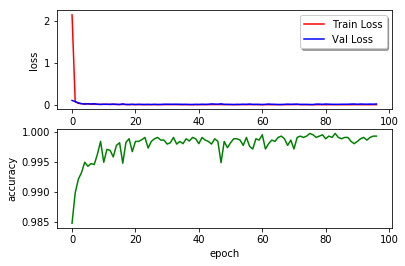

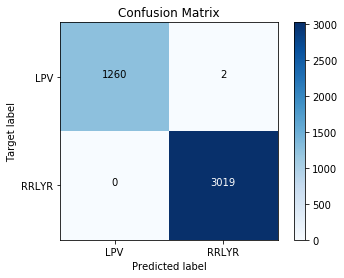

EPOCH: 98
TRAIN LOSS: 0.0009895683682463645
VAL LOSS: 0.01969819006807935
VAL ACCURACY: 99.8 %
TIME: 62.8 s


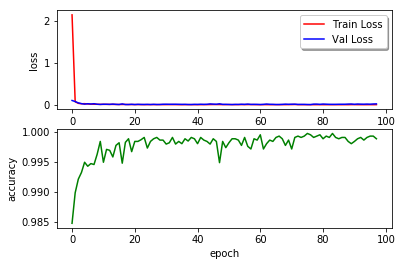

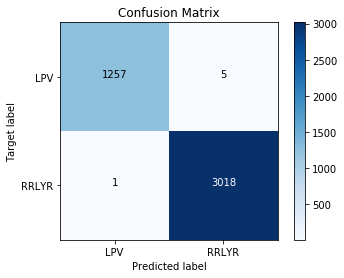

EPOCH: 99
TRAIN LOSS: 0.00032658325320545316
VAL LOSS: 0.013702703381475034
VAL ACCURACY: 99.8 %
TIME: 62.0 s


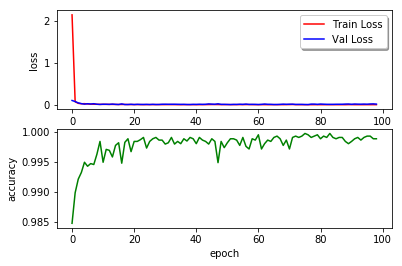

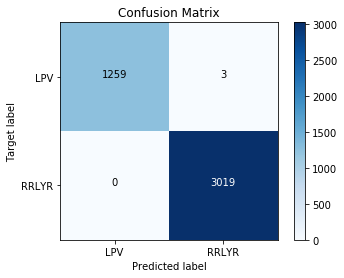

EPOCH: 100
TRAIN LOSS: 0.0001422845292912657
VAL LOSS: 0.014186735008758255
VAL ACCURACY: 99.9 %
TIME: 61.9 s


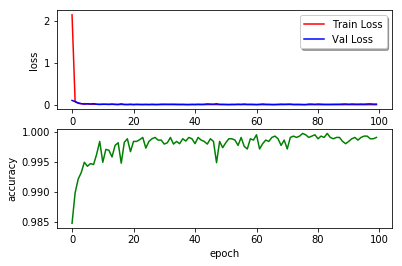

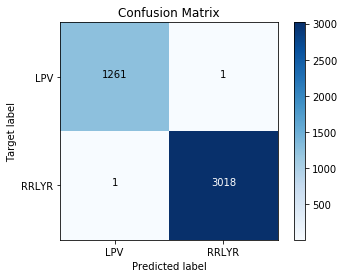

EPOCH: 101
TRAIN LOSS: 0.00024040576965546863
VAL LOSS: 0.009772018971872696
VAL ACCURACY: 99.9 %
TIME: 62.0 s


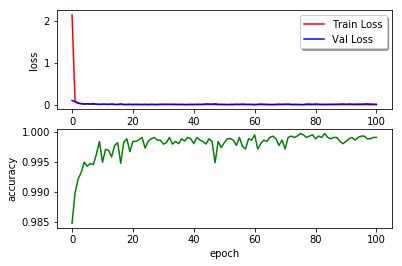

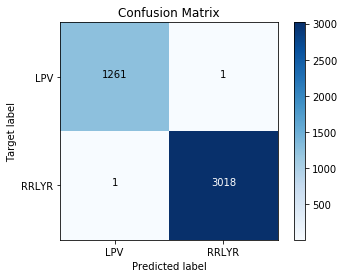

EPOCH: 102
TRAIN LOSS: 0.0001366512865314437
VAL LOSS: 0.012023275915256988
VAL ACCURACY: 99.9 %
TIME: 61.9 s


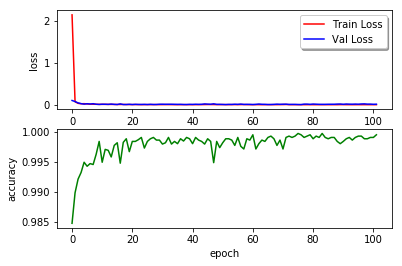

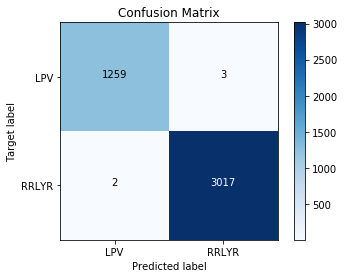

EPOCH: 103
TRAIN LOSS: 0.0019863541541326793
VAL LOSS: 0.024026404307350105
VAL ACCURACY: 99.8 %
TIME: 62.0 s


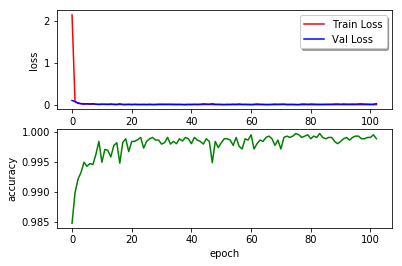

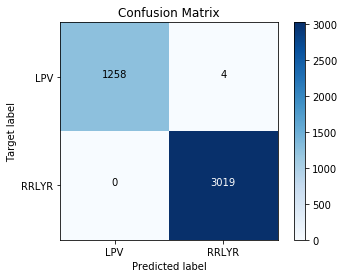

EPOCH: 104
TRAIN LOSS: 0.0018135278174194163
VAL LOSS: 0.01899092592676726
VAL ACCURACY: 99.8 %
TIME: 61.3 s


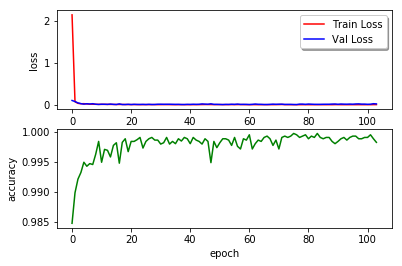

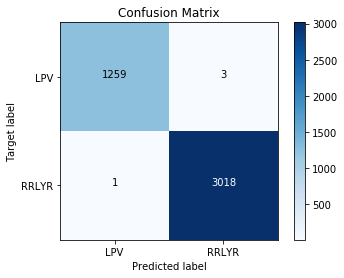

EPOCH: 105
TRAIN LOSS: 0.0008214427280522665
VAL LOSS: 0.02015793115414
VAL ACCURACY: 99.8 %
TIME: 60.3 s


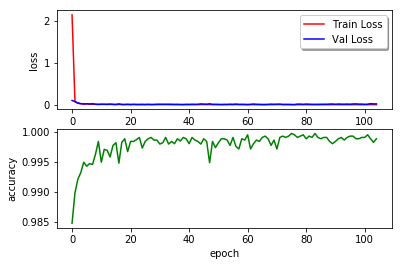

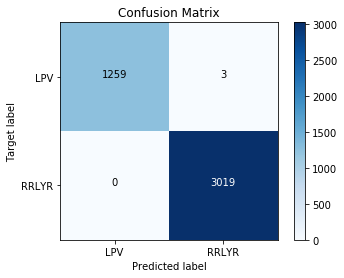

EPOCH: 106
TRAIN LOSS: 0.00146733965749382
VAL LOSS: 0.010751674775624496
VAL ACCURACY: 99.9 %
TIME: 60.1 s


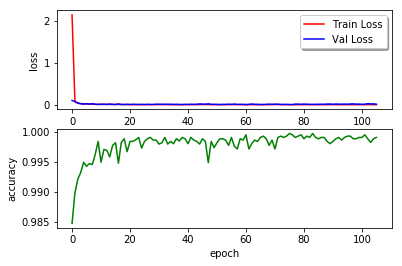

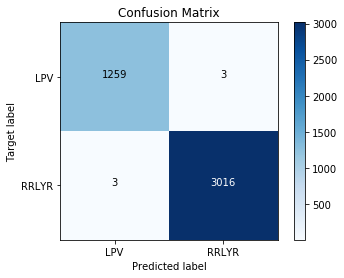

EPOCH: 107
TRAIN LOSS: 9.644038528030036e-06
VAL LOSS: 0.01212155299866351
VAL ACCURACY: 99.9 %
TIME: 60.2 s


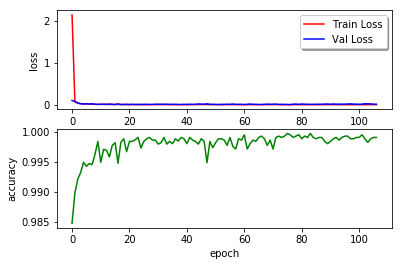

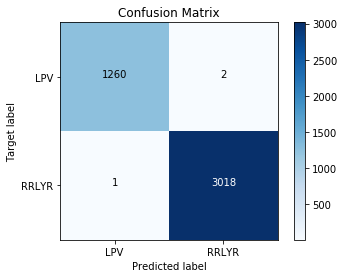

EPOCH: 108
TRAIN LOSS: 0.0008473569607230074
VAL LOSS: 0.012806626446064952
VAL ACCURACY: 99.9 %
TIME: 59.6 s


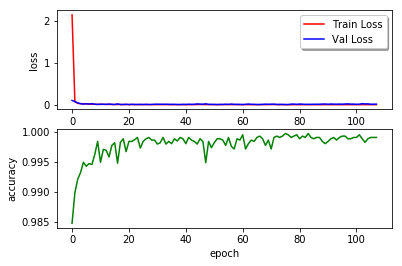

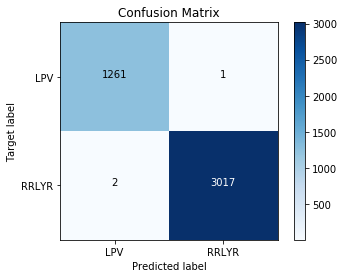

EPOCH: 109
TRAIN LOSS: 0.00012843702614961285
VAL LOSS: 0.011937536409057035
VAL ACCURACY: 99.9 %
TIME: 59.0 s


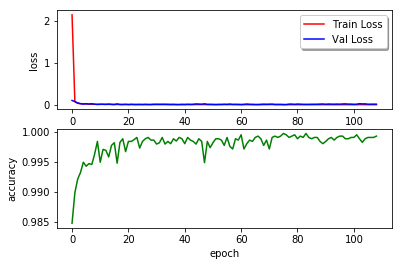

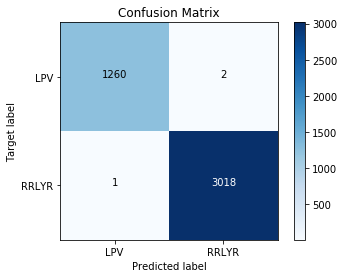

EPOCH: 110
TRAIN LOSS: 7.186036486865623e-06
VAL LOSS: 0.01982642100331181
VAL ACCURACY: 99.9 %
TIME: 58.8 s


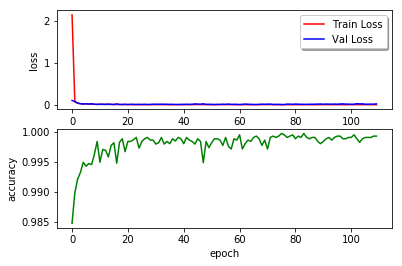

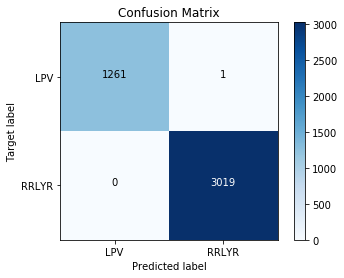

EPOCH: 111
TRAIN LOSS: 6.549749834027935e-05
VAL LOSS: 0.004531397055916643
VAL ACCURACY: 99.9 %
TIME: 58.6 s


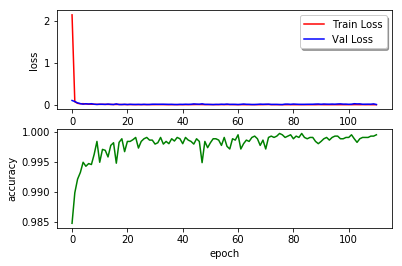

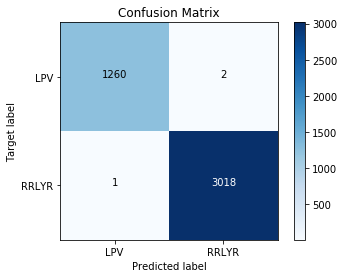

EPOCH: 112
TRAIN LOSS: 0.0006655984548192659
VAL LOSS: 0.01302922075923771
VAL ACCURACY: 99.9 %
TIME: 58.6 s


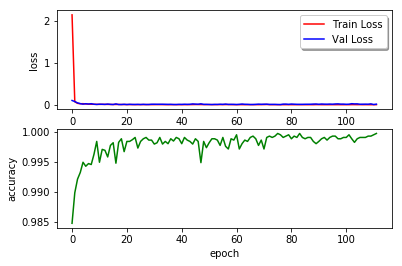

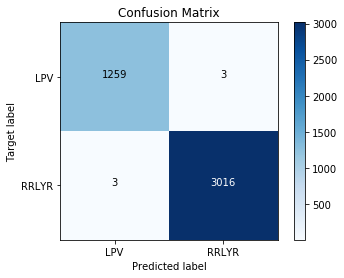

EPOCH: 113
TRAIN LOSS: 0.00015751905587100697
VAL LOSS: 0.015866676036580908
VAL ACCURACY: 99.9 %
TIME: 58.5 s


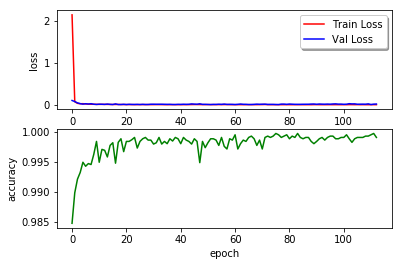

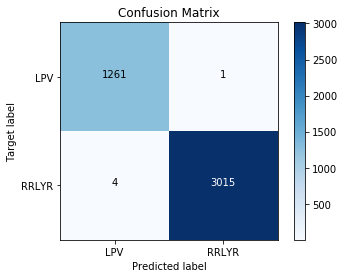

EPOCH: 114
TRAIN LOSS: 2.5052386297816424e-05
VAL LOSS: 0.013021782979850568
VAL ACCURACY: 99.9 %
TIME: 58.5 s


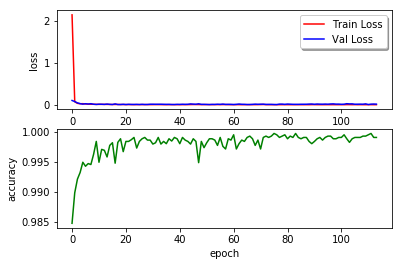

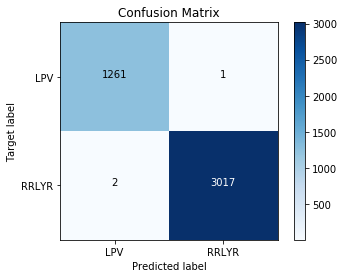

EPOCH: 115
TRAIN LOSS: 0.00013144528459563704
VAL LOSS: 0.018654949204918204
VAL ACCURACY: 99.8 %
TIME: 58.4 s


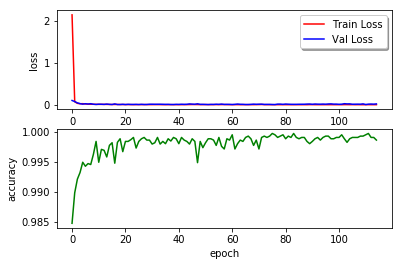

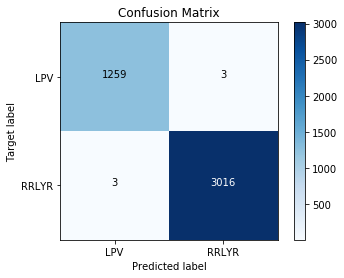

EPOCH: 116
TRAIN LOSS: 0.0002942923836292126
VAL LOSS: 0.01587531117356784
VAL ACCURACY: 99.8 %
TIME: 58.3 s


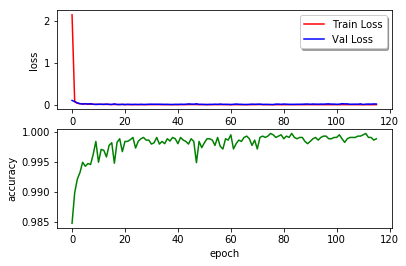

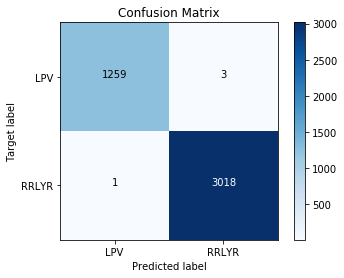

EPOCH: 117
TRAIN LOSS: 0.0003850752614930153
VAL LOSS: 0.015043220121351685
VAL ACCURACY: 99.9 %
TIME: 57.9 s


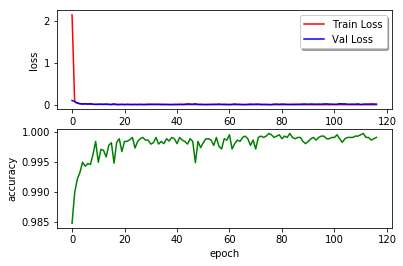

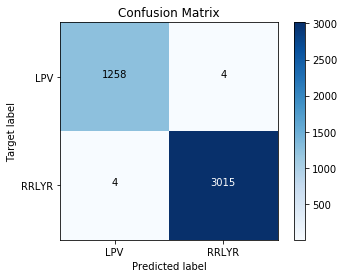

EPOCH: 118
TRAIN LOSS: 0.00019011045435502204
VAL LOSS: 0.0175732689959441
VAL ACCURACY: 99.8 %
TIME: 58.0 s


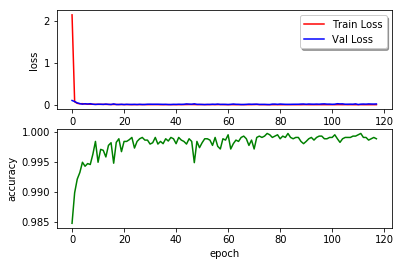

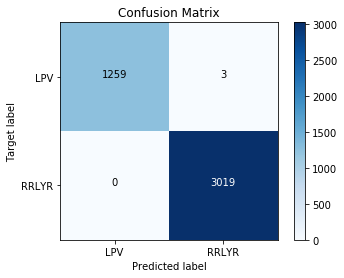

EPOCH: 119
TRAIN LOSS: 0.0011671766427318276
VAL LOSS: 0.009051337894987613
VAL ACCURACY: 99.9 %
TIME: 58.1 s


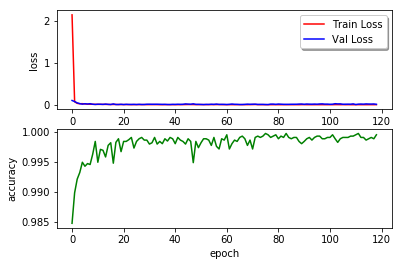

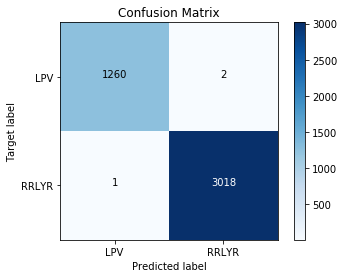

EPOCH: 120
TRAIN LOSS: 0.0007678352056913766
VAL LOSS: 0.03593424669766519
VAL ACCURACY: 99.7 %
TIME: 58.0 s


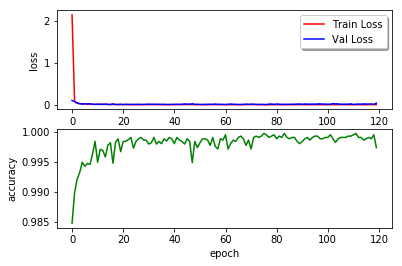

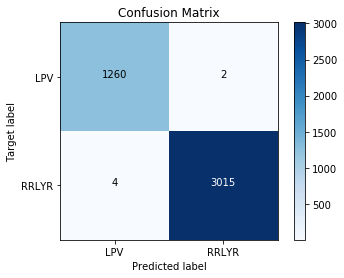

EPOCH: 121
TRAIN LOSS: 0.0011451254946136732
VAL LOSS: 0.03125917372194949
VAL ACCURACY: 99.9 %
TIME: 57.8 s


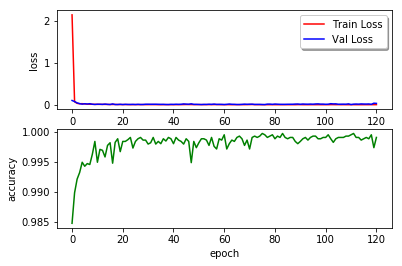

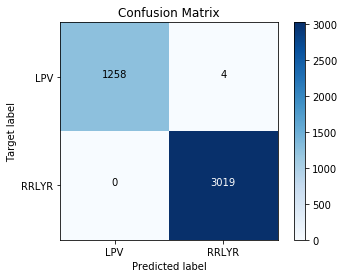

EPOCH: 122
TRAIN LOSS: 0.0011136508934207023
VAL LOSS: 0.027856100152088552
VAL ACCURACY: 99.8 %
TIME: 58.2 s


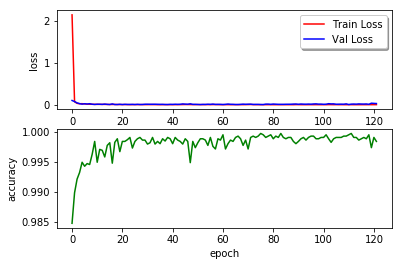

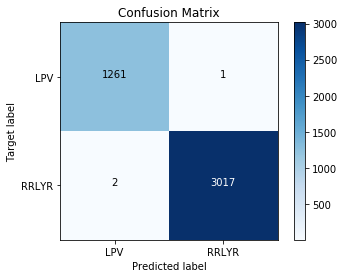

EPOCH: 123
TRAIN LOSS: 0.0014510555088650813
VAL LOSS: 0.021063209878860907
VAL ACCURACY: 99.9 %
TIME: 58.8 s


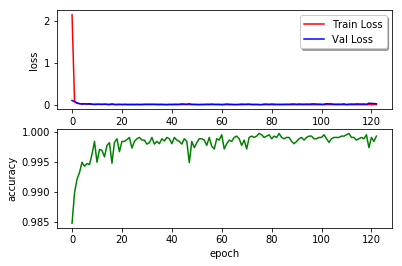

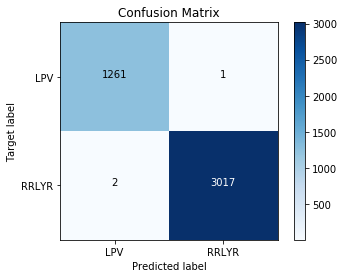

EPOCH: 124
TRAIN LOSS: 0.002779411979947922
VAL LOSS: 0.003764615041266398
VAL ACCURACY: 99.9 %
TIME: 58.8 s


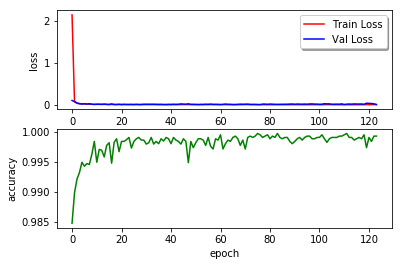

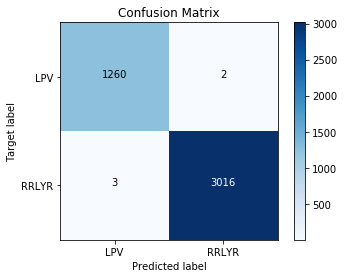

EPOCH: 125
TRAIN LOSS: 0.002604556275966842
VAL LOSS: 0.01686702115594263
VAL ACCURACY: 99.9 %
TIME: 58.9 s


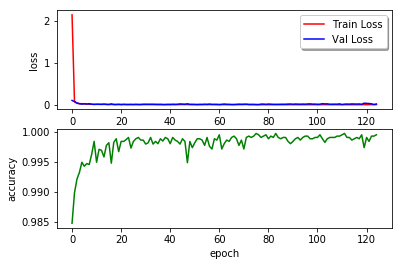

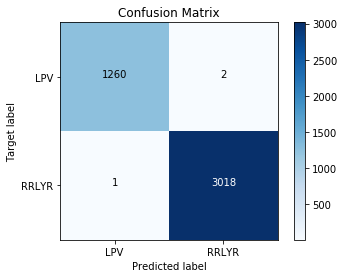

EPOCH: 126
TRAIN LOSS: 0.0007673049158464843
VAL LOSS: 0.014820268926946401
VAL ACCURACY: 99.9 %
TIME: 58.7 s


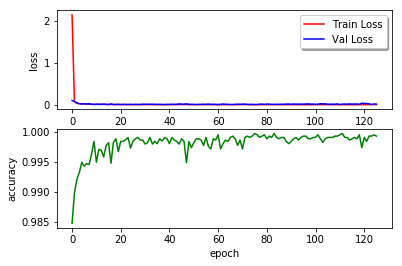

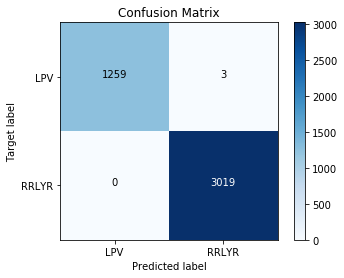

EPOCH: 127
TRAIN LOSS: 0.0013131284792127866
VAL LOSS: 0.0028776985488357643
VAL ACCURACY: 99.9 %
TIME: 58.6 s


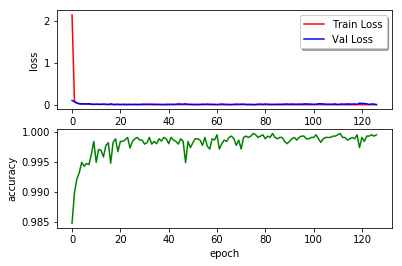

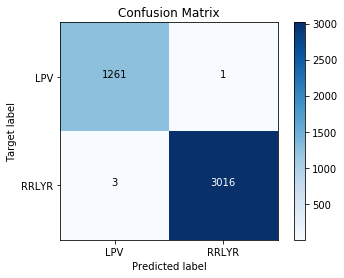

EPOCH: 128
TRAIN LOSS: 0.00022780781629973783
VAL LOSS: 0.01745709605011692
VAL ACCURACY: 99.9 %
TIME: 58.7 s


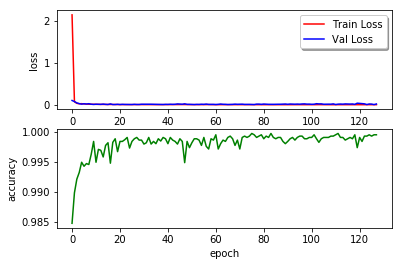

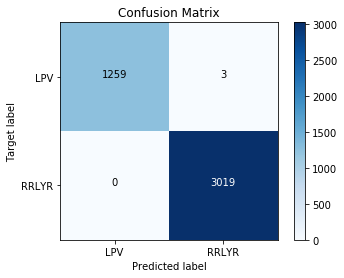

EPOCH: 129
TRAIN LOSS: 0.0009330275021985328
VAL LOSS: 0.011484467475199515
VAL ACCURACY: 99.9 %
TIME: 59.0 s


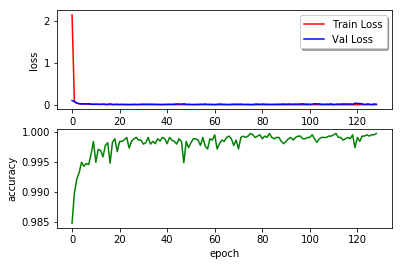

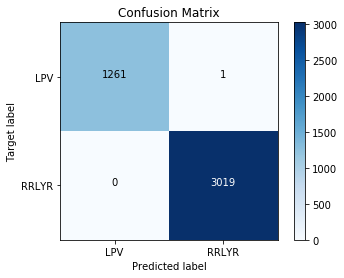

EPOCH: 130
TRAIN LOSS: 0.00029344394319113484
VAL LOSS: 0.010206642990549412
VAL ACCURACY: 99.9 %
TIME: 57.6 s


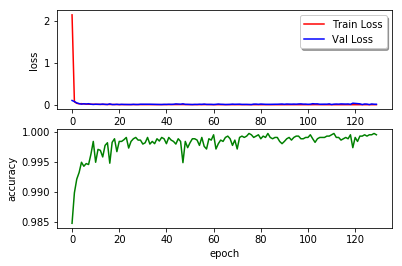

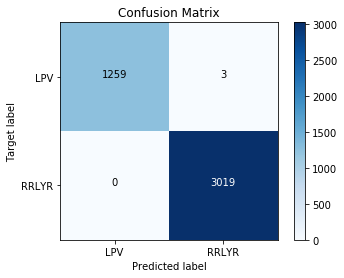

EPOCH: 131
TRAIN LOSS: 7.704167916868784e-05
VAL LOSS: 0.014173825778869203
VAL ACCURACY: 99.9 %
TIME: 58.6 s


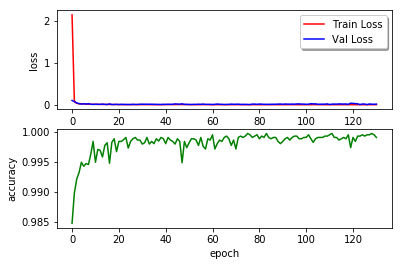

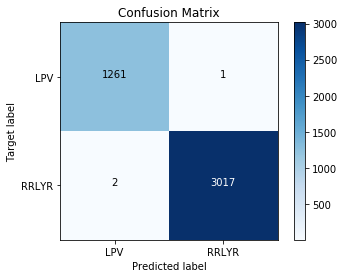

EPOCH: 132
TRAIN LOSS: 1.176457257022485e-05
VAL LOSS: 0.01231512819022181
VAL ACCURACY: 99.9 %
TIME: 58.4 s


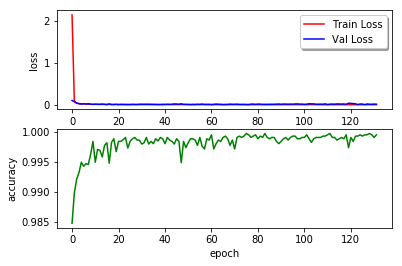

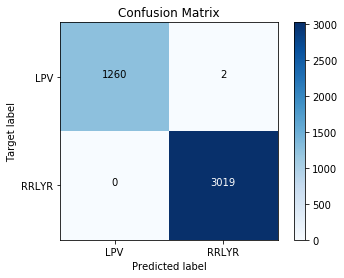

EPOCH: 133
TRAIN LOSS: 1.329283562253901e-06
VAL LOSS: 0.01148721407980648
VAL ACCURACY: 99.9 %
TIME: 57.5 s


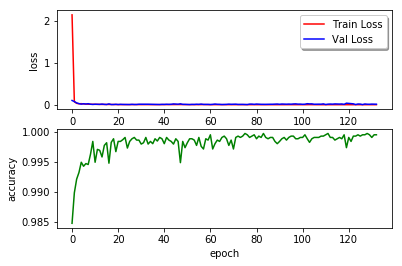

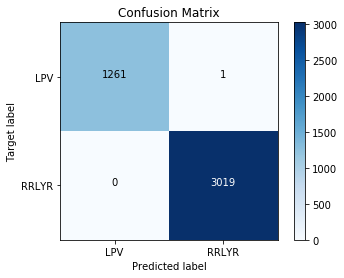

EPOCH: 134
TRAIN LOSS: 5.426574051316654e-05
VAL LOSS: 0.015598218171590524
VAL ACCURACY: 99.9 %
TIME: 57.6 s


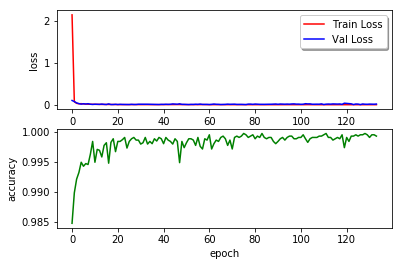

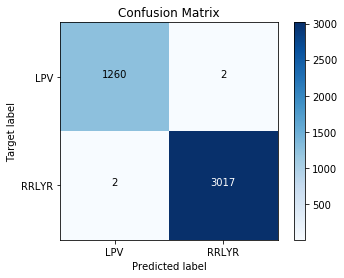

EPOCH: 135
TRAIN LOSS: 0.0009279779034361406
VAL LOSS: 0.017425170487187162
VAL ACCURACY: 99.9 %
TIME: 57.2 s


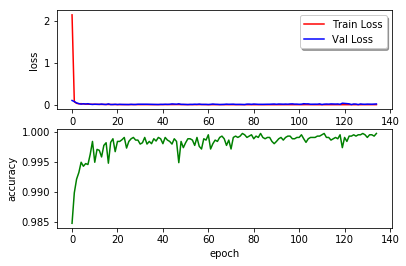

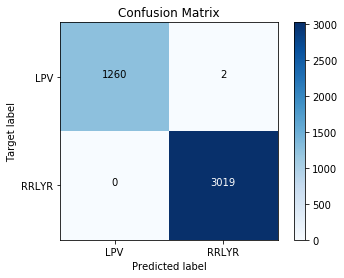

EPOCH: 136
TRAIN LOSS: 0.00019137116539782428
VAL LOSS: 0.01961445909472461
VAL ACCURACY: 99.9 %
TIME: 57.4 s


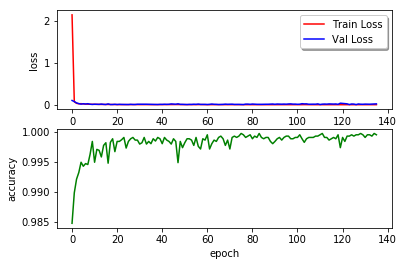

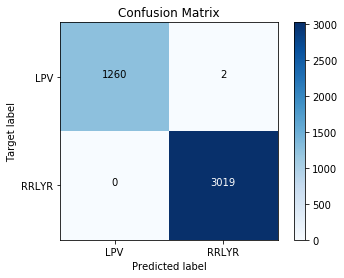

EPOCH: 137
TRAIN LOSS: 0.00029466343191002014
VAL LOSS: 0.014443748393065189
VAL ACCURACY: 99.9 %
TIME: 57.2 s


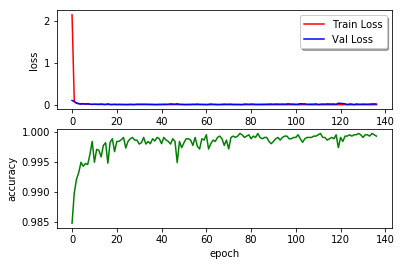

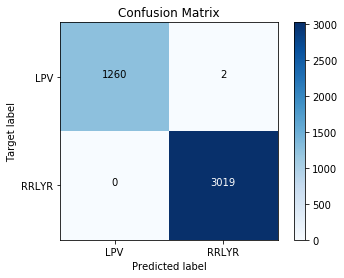

EPOCH: 138
TRAIN LOSS: 1.1228429831979564e-05
VAL LOSS: 0.018898660552724714
VAL ACCURACY: 99.9 %
TIME: 57.5 s


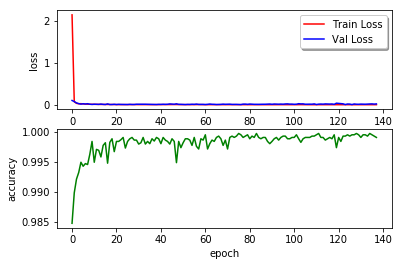

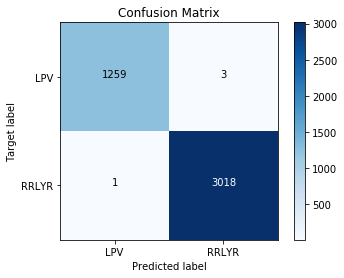

EPOCH: 139
TRAIN LOSS: 0.0006404909262965009
VAL LOSS: 0.018069407046301736
VAL ACCURACY: 99.8 %
TIME: 58.4 s


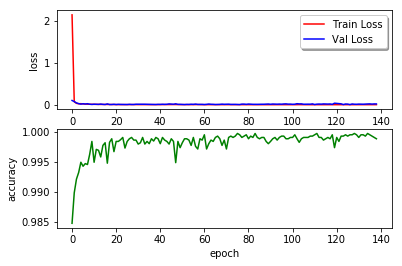

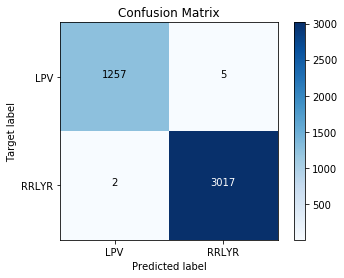

EPOCH: 140
TRAIN LOSS: 0.0008404083227021584
VAL LOSS: 0.011819012255894639
VAL ACCURACY: 99.9 %
TIME: 57.8 s


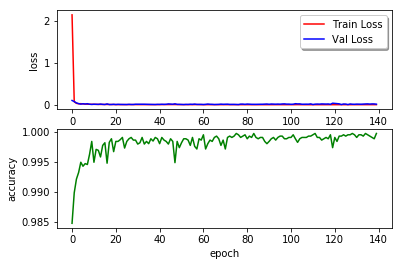

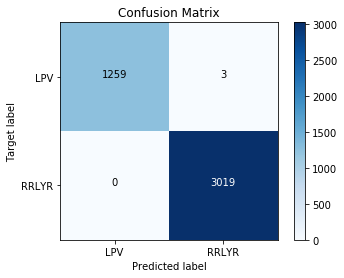

EPOCH: 141
TRAIN LOSS: 0.00010274288818550775
VAL LOSS: 0.020166787145525746
VAL ACCURACY: 99.9 %
TIME: 57.5 s


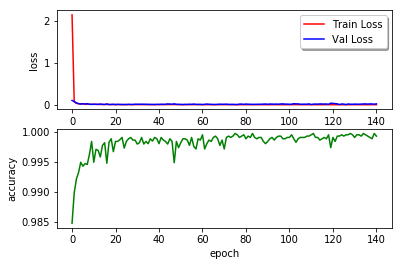

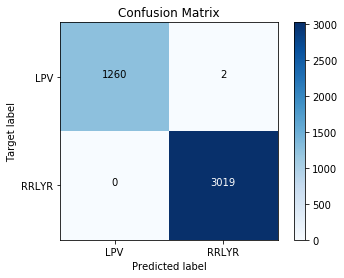

EPOCH: 142
TRAIN LOSS: 4.9679889104468424e-05
VAL LOSS: 0.02141412475121253
VAL ACCURACY: 99.9 %
TIME: 57.4 s


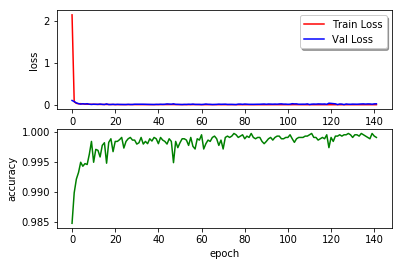

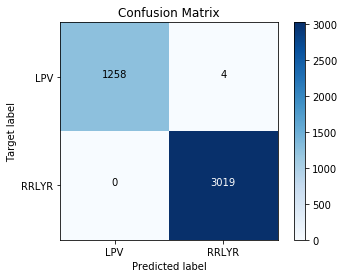

EPOCH: 143
TRAIN LOSS: 0.000138106641448418
VAL LOSS: 0.025159260437735583
VAL ACCURACY: 99.9 %
TIME: 57.3 s


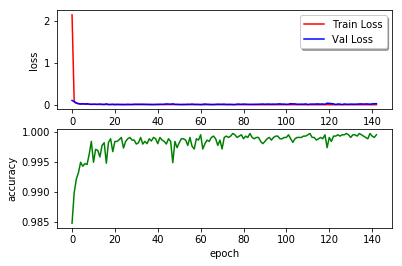

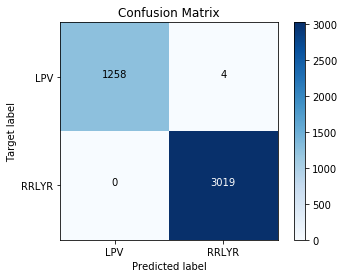

EPOCH: 144
TRAIN LOSS: 2.8351787870633314e-05
VAL LOSS: 0.015749079665087477
VAL ACCURACY: 99.9 %
TIME: 58.3 s


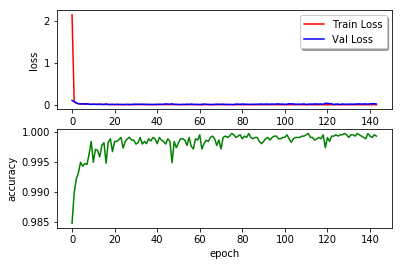

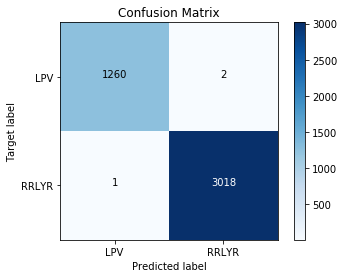

EPOCH: 145
TRAIN LOSS: 4.791879385837647e-07
VAL LOSS: 0.012511288777644035
VAL ACCURACY: 99.9 %
TIME: 57.3 s


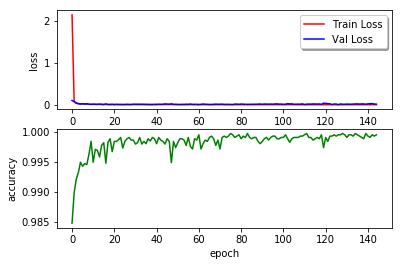

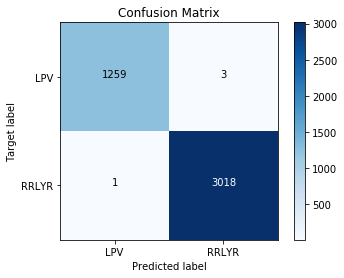

EPOCH: 146
TRAIN LOSS: 9.99261493457107e-06
VAL LOSS: 0.018203746730488617
VAL ACCURACY: 99.9 %
TIME: 58.1 s


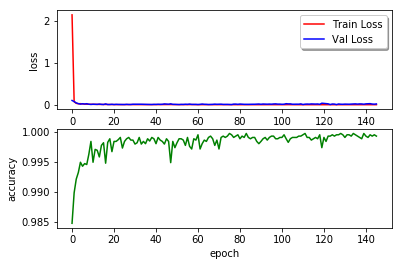

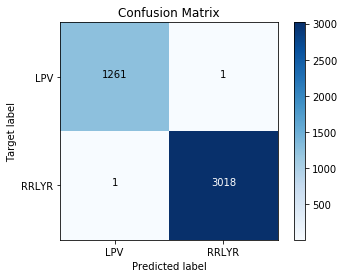

EPOCH: 147
TRAIN LOSS: 0.0004014729356484951
VAL LOSS: 0.016830000637804887
VAL ACCURACY: 99.8 %
TIME: 58.8 s


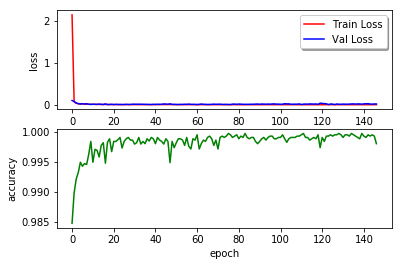

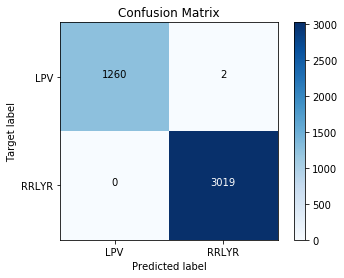

EPOCH: 148
TRAIN LOSS: 0.00025269072549332917
VAL LOSS: 0.01871237991756184
VAL ACCURACY: 99.9 %
TIME: 58.1 s


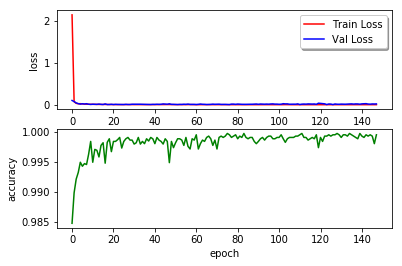

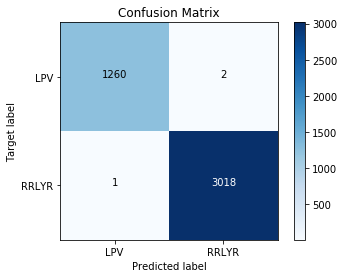

EPOCH: 149
TRAIN LOSS: 0.0005339900442419721
VAL LOSS: 0.023461160733544293
VAL ACCURACY: 99.8 %
TIME: 58.2 s


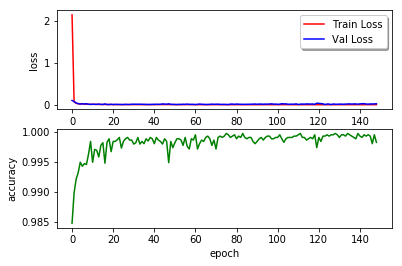

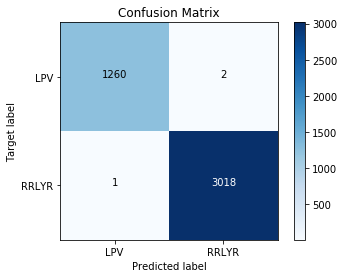

EPOCH: 150
TRAIN LOSS: 0.001396456358110327
VAL LOSS: 0.010303772847332244
VAL ACCURACY: 99.9 %
TIME: 58.3 s


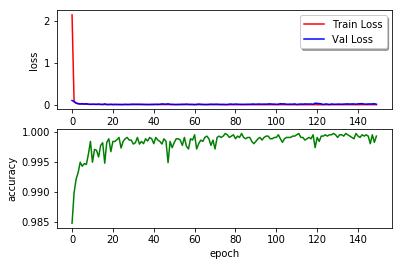

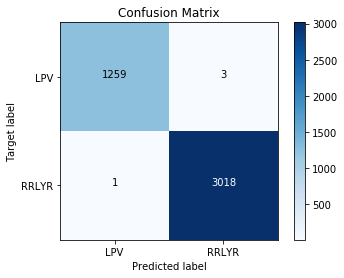

EPOCH: 151
TRAIN LOSS: 0.00016667342228591906
VAL LOSS: 0.013620718538434164
VAL ACCURACY: 99.9 %
TIME: 57.7 s


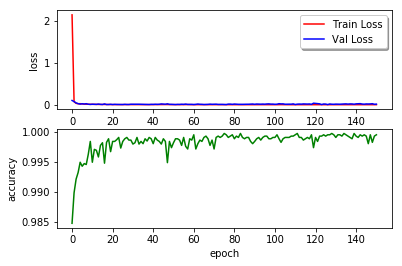

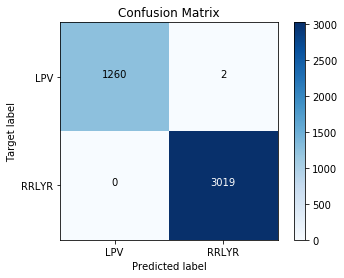

EPOCH: 152
TRAIN LOSS: 0.0002971492640756903
VAL LOSS: 0.01902311782346707
VAL ACCURACY: 99.8 %
TIME: 57.2 s


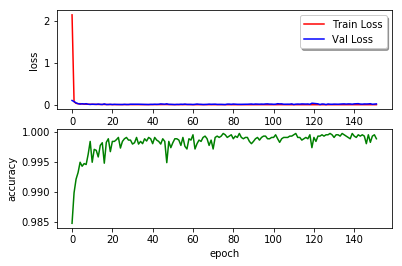

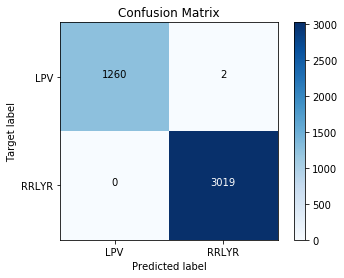

EPOCH: 153
TRAIN LOSS: 0.0005414423322661028
VAL LOSS: 0.02211601842955229
VAL ACCURACY: 99.9 %
TIME: 58.6 s


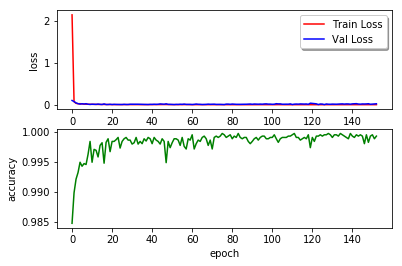

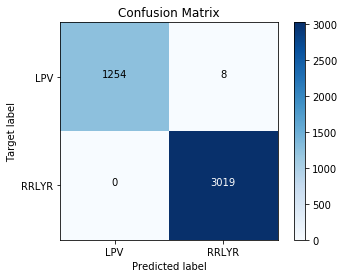

EPOCH: 154
TRAIN LOSS: 0.0003193506304973849
VAL LOSS: 0.024556980228380047
VAL ACCURACY: 99.8 %
TIME: 62.4 s


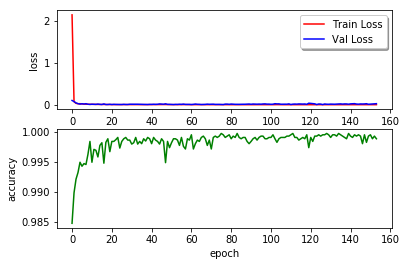

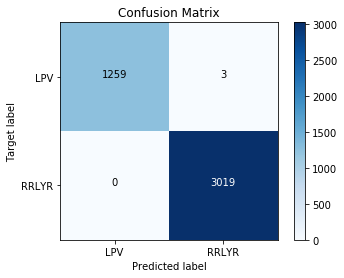

EPOCH: 155
TRAIN LOSS: 0.000684886898230253
VAL LOSS: 0.02542398660921973
VAL ACCURACY: 99.9 %
TIME: 60.5 s


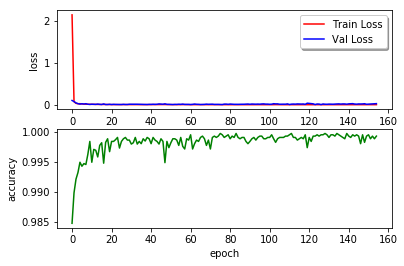

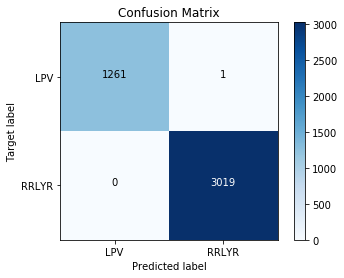

EPOCH: 156
TRAIN LOSS: 0.0005101690310245257
VAL LOSS: 0.021159668421329995
VAL ACCURACY: 99.9 %
TIME: 58.4 s


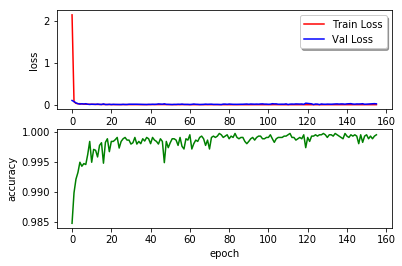

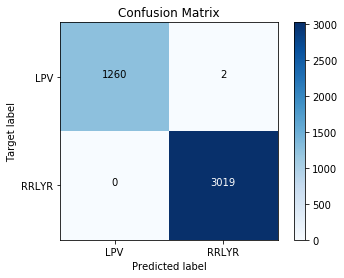

EPOCH: 157
TRAIN LOSS: 1.9685598181469046e-07
VAL LOSS: 0.015450991485499015
VAL ACCURACY: 99.9 %
TIME: 59.0 s


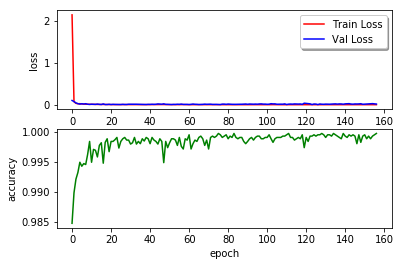

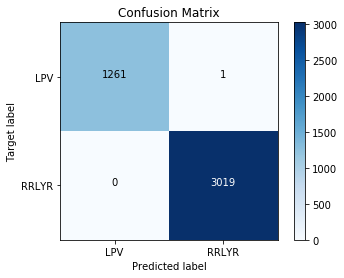

EPOCH: 158
TRAIN LOSS: 1.2765264311341987e-05
VAL LOSS: 0.012350024270832233
VAL ACCURACY: 99.9 %
TIME: 59.9 s


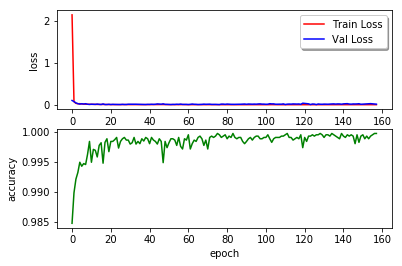

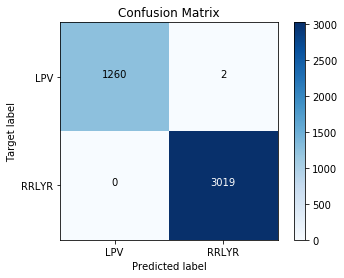

EPOCH: 159
TRAIN LOSS: 1.0208202194731272e-05
VAL LOSS: 0.018018918782923353
VAL ACCURACY: 99.9 %
TIME: 57.5 s


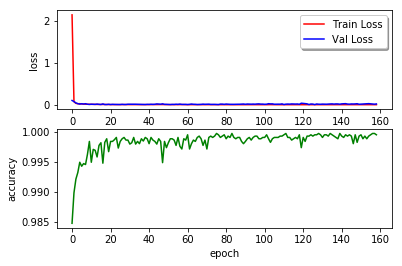

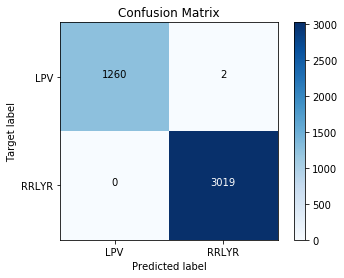

EPOCH: 160
TRAIN LOSS: 3.755170382467984e-05
VAL LOSS: 0.019103015013949266
VAL ACCURACY: 99.9 %
TIME: 58.1 s


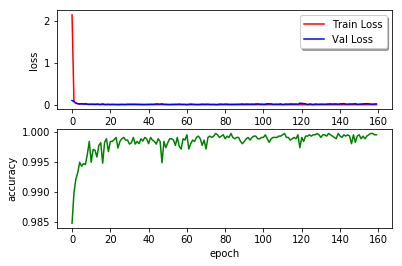

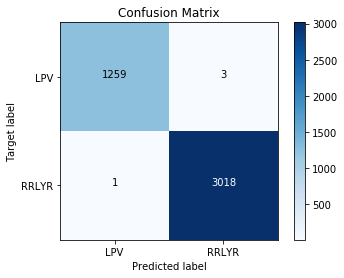

EPOCH: 161
TRAIN LOSS: 0.0001969257507224804
VAL LOSS: 0.018703524086112786
VAL ACCURACY: 99.9 %
TIME: 58.3 s


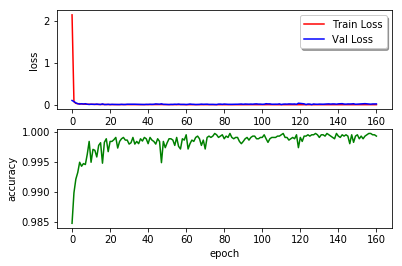

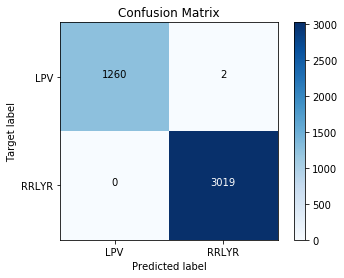

EPOCH: 162
TRAIN LOSS: 4.784612608491169e-07
VAL LOSS: 0.023313756349494213
VAL ACCURACY: 99.8 %
TIME: 58.4 s


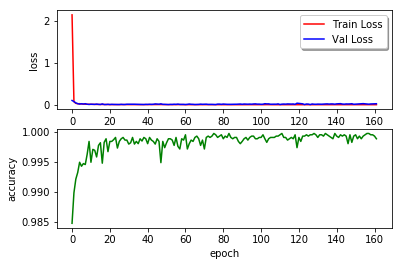

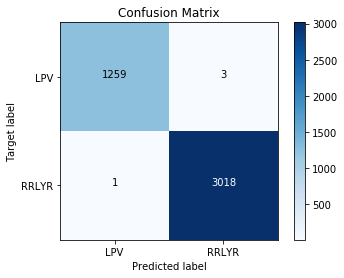

EPOCH: 163
TRAIN LOSS: 0.0012095972849112734
VAL LOSS: 0.0101657839716787
VAL ACCURACY: 99.9 %
TIME: 59.5 s


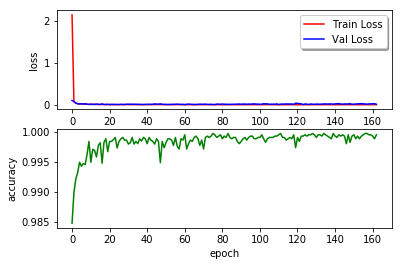

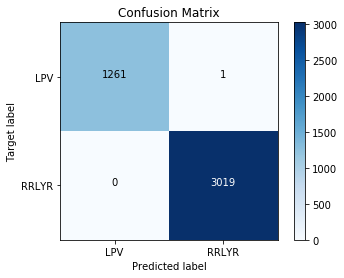

EPOCH: 164
TRAIN LOSS: 3.587451706627466e-05
VAL LOSS: 0.0099875319519885
VAL ACCURACY: 99.9 %
TIME: 60.4 s


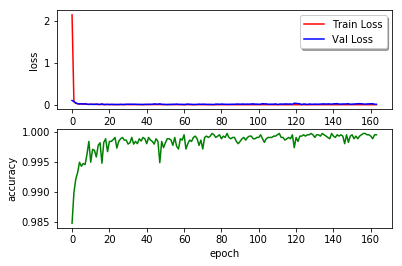

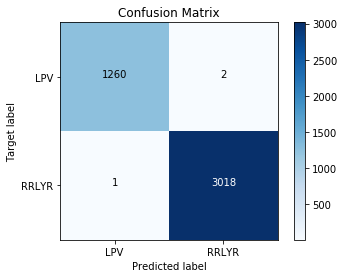

EPOCH: 165
TRAIN LOSS: 0.00017855822592317515
VAL LOSS: 0.01675126641570108
VAL ACCURACY: 99.9 %
TIME: 63.9 s


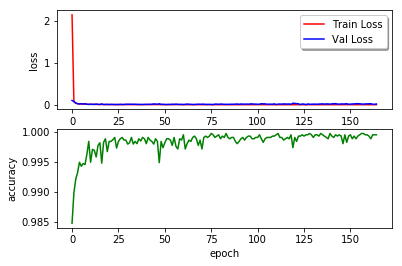

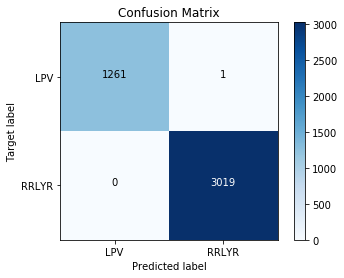

EPOCH: 166
TRAIN LOSS: 2.258922734777395e-07
VAL LOSS: 0.007545941565969904
VAL ACCURACY: 99.9 %
TIME: 61.2 s


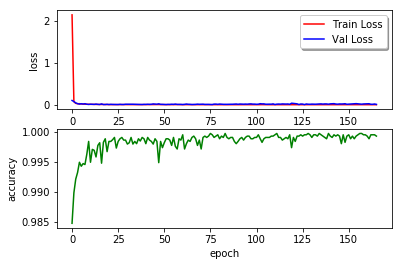

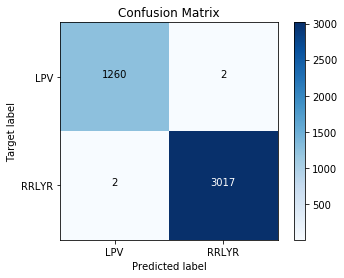

EPOCH: 167
TRAIN LOSS: 0.0003546374748332912
VAL LOSS: 0.011845913658492193
VAL ACCURACY: 99.9 %
TIME: 61.0 s


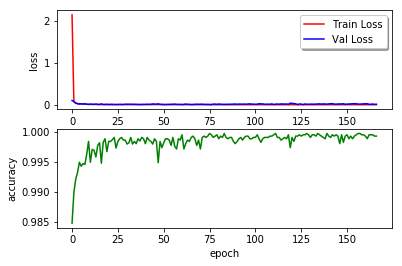

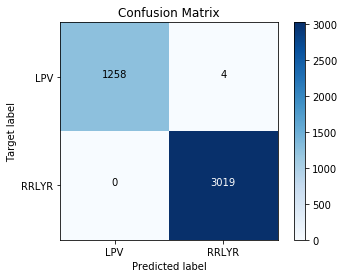

EPOCH: 168
TRAIN LOSS: 0.0010059823659188329
VAL LOSS: 0.009293135936923174
VAL ACCURACY: 99.9 %
TIME: 61.0 s


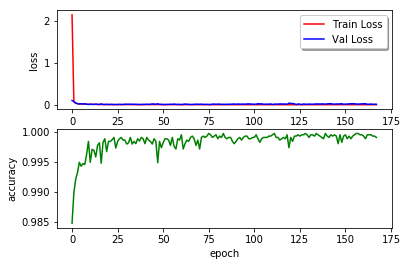

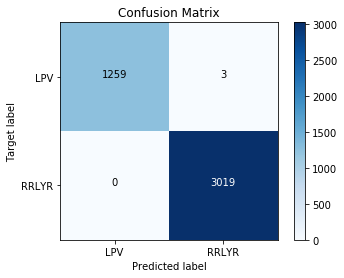

EPOCH: 169
TRAIN LOSS: 8.04750718621417e-05
VAL LOSS: 0.02169107965342699
VAL ACCURACY: 99.8 %
TIME: 60.0 s


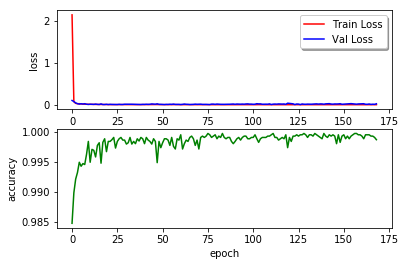

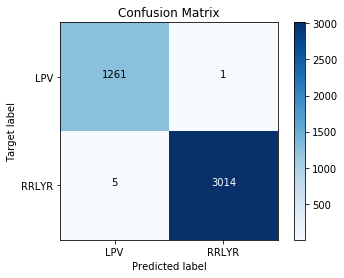

EPOCH: 170
TRAIN LOSS: 0.00011411694205900748
VAL LOSS: 0.029403897855227776
VAL ACCURACY: 99.8 %
TIME: 61.2 s


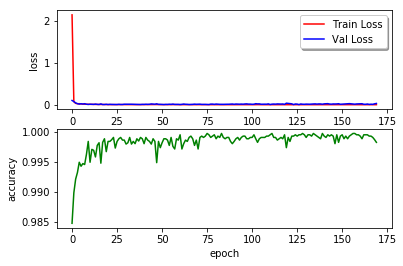

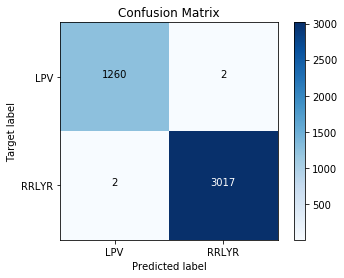

EPOCH: 171
TRAIN LOSS: 5.2963886353578174e-05
VAL LOSS: 0.021187719663711906
VAL ACCURACY: 99.8 %
TIME: 60.9 s


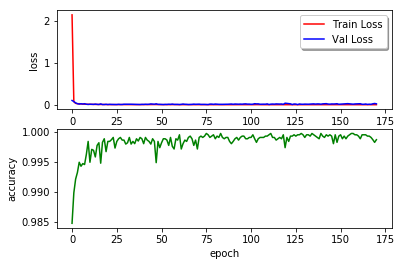

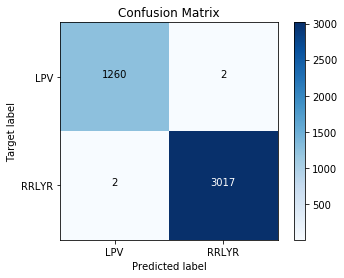

EPOCH: 172
TRAIN LOSS: 4.698031096905218e-06
VAL LOSS: 0.02627956700388139
VAL ACCURACY: 99.8 %
TIME: 58.1 s


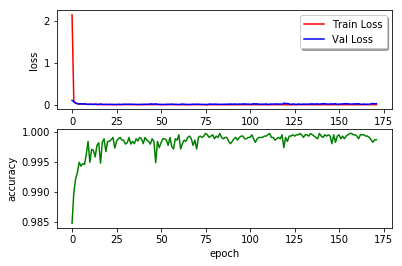

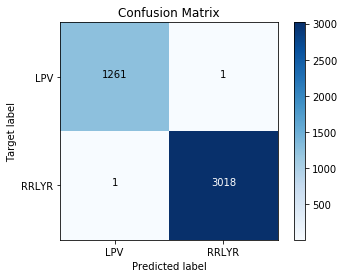

EPOCH: 173
TRAIN LOSS: 0.0006434731836595122
VAL LOSS: 0.017093303293938038
VAL ACCURACY: 99.9 %
TIME: 58.0 s


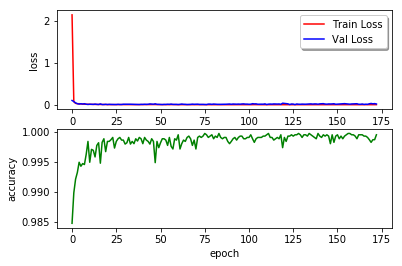

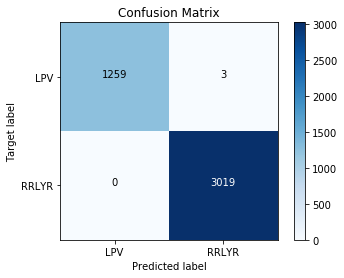

EPOCH: 174
TRAIN LOSS: 2.2167650187482492e-08
VAL LOSS: 0.01278686851579003
VAL ACCURACY: 99.9 %
TIME: 58.1 s


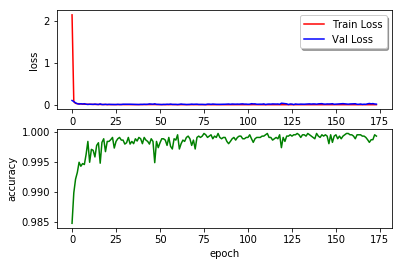

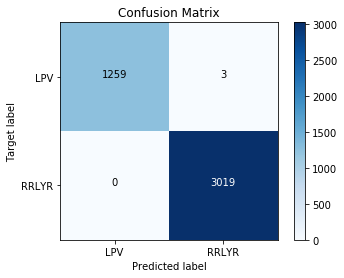

EPOCH: 175
TRAIN LOSS: 0.00023654354908169632
VAL LOSS: 0.017788375221893936
VAL ACCURACY: 99.9 %
TIME: 58.1 s


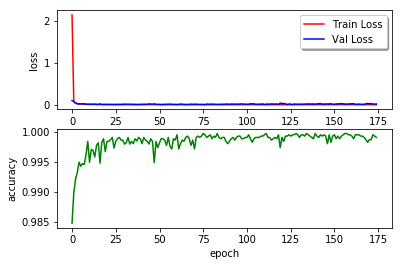

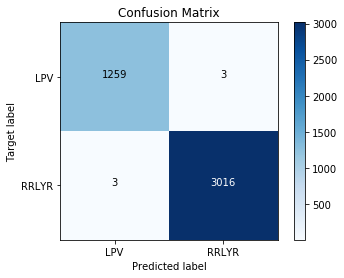

EPOCH: 176
TRAIN LOSS: 6.690985348292071e-05
VAL LOSS: 0.011954310646637583
VAL ACCURACY: 99.9 %
TIME: 58.1 s


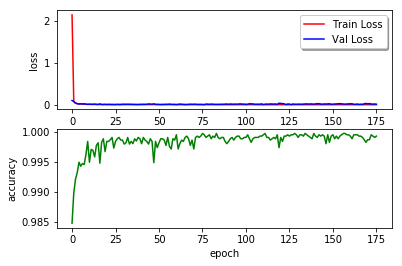

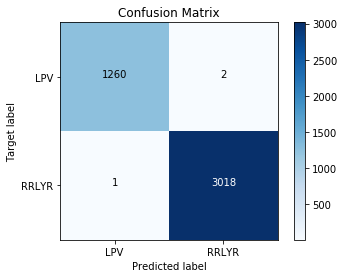

EPOCH: 177
TRAIN LOSS: 3.236760941172838e-08
VAL LOSS: 0.026062329560206595
VAL ACCURACY: 99.8 %
TIME: 58.0 s


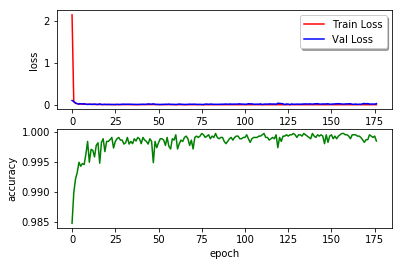

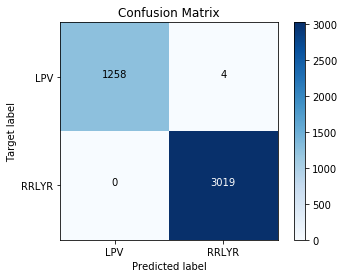

EPOCH: 178
TRAIN LOSS: 1.8596984244807732e-05
VAL LOSS: 0.01956837255493984
VAL ACCURACY: 99.9 %
TIME: 58.1 s


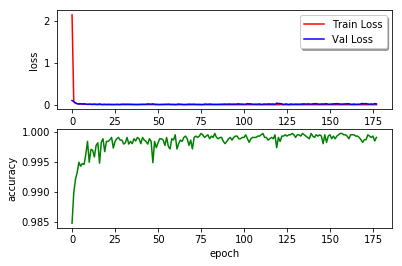

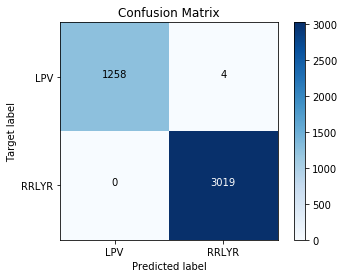

EPOCH: 179
TRAIN LOSS: 0.00011212365466213327
VAL LOSS: 0.016652251508739488
VAL ACCURACY: 99.9 %
TIME: 58.1 s


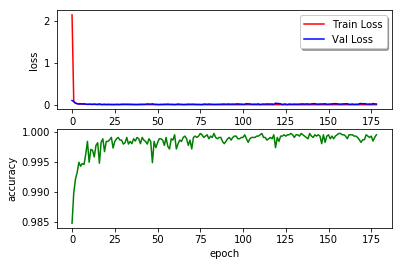

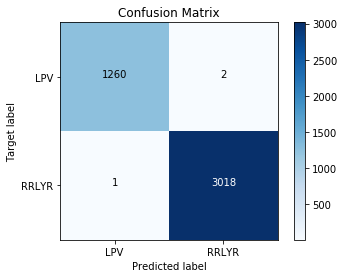

EPOCH: 180
TRAIN LOSS: 1.0124571996820848e-05
VAL LOSS: 0.016846948740750992
VAL ACCURACY: 99.9 %
TIME: 58.1 s


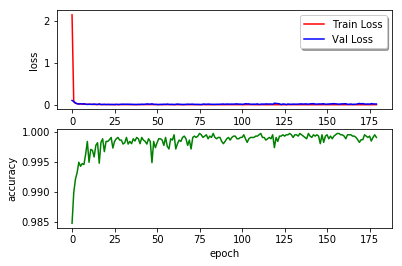

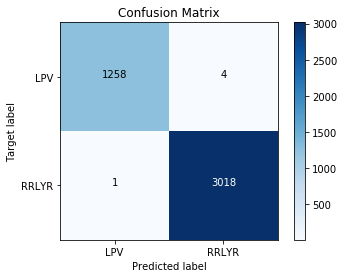

EPOCH: 181
TRAIN LOSS: 0.001988807318857088
VAL LOSS: 0.014051647835429499
VAL ACCURACY: 99.9 %
TIME: 59.8 s


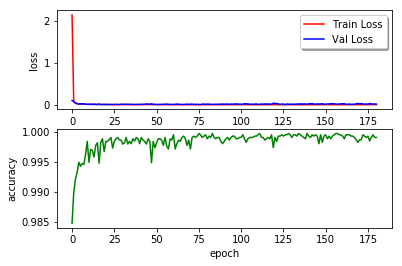

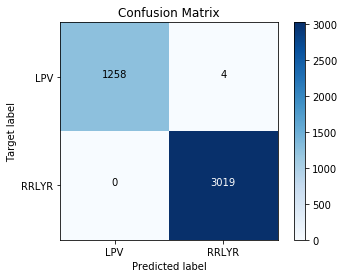

EPOCH: 182
TRAIN LOSS: 0.00012065995614286917
VAL LOSS: 0.013611933181502963
VAL ACCURACY: 99.9 %
TIME: 59.0 s


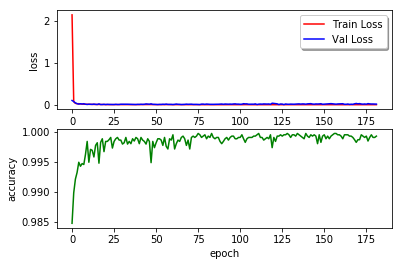

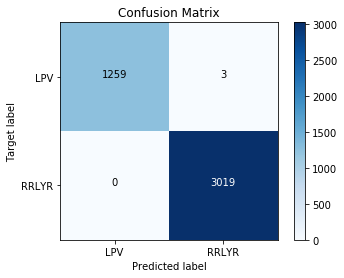

EPOCH: 183
TRAIN LOSS: 8.84651707329803e-07
VAL LOSS: 0.02123502006075448
VAL ACCURACY: 99.9 %
TIME: 59.0 s


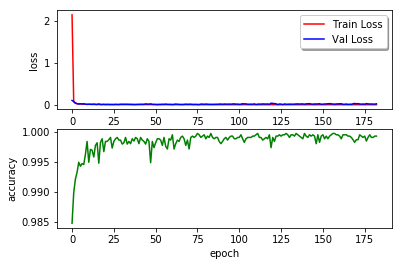

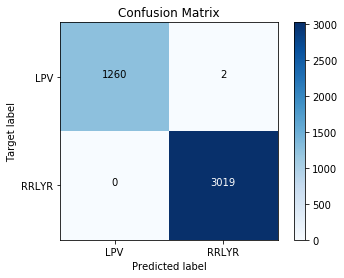

EPOCH: 184
TRAIN LOSS: 0.00029826707753072144
VAL LOSS: 0.024291204694233782
VAL ACCURACY: 99.8 %
TIME: 60.1 s


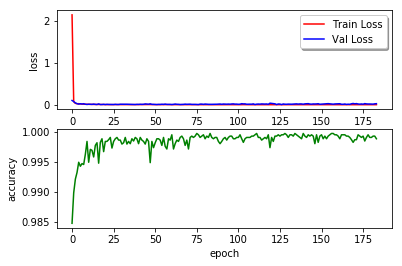

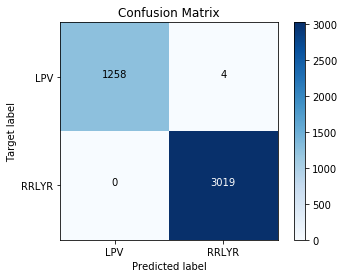

EPOCH: 185
TRAIN LOSS: 0.0027159626309760684
VAL LOSS: 0.013478646838052593
VAL ACCURACY: 99.9 %
TIME: 61.3 s


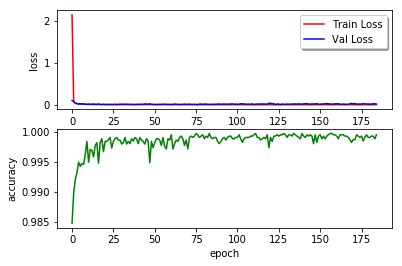

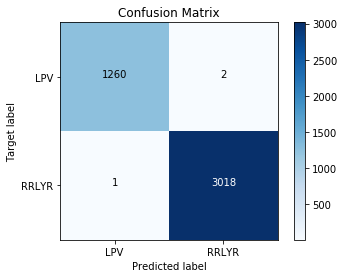

EPOCH: 186
TRAIN LOSS: 0.0016713948792523683
VAL LOSS: 0.01728572794499095
VAL ACCURACY: 99.9 %
TIME: 61.0 s


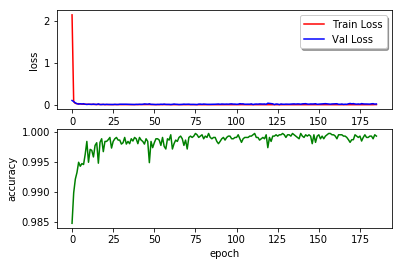

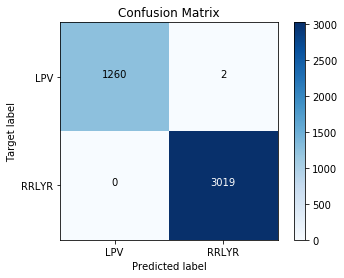

EPOCH: 187
TRAIN LOSS: 5.383791079664723e-06
VAL LOSS: 0.025922416952247798
VAL ACCURACY: 99.9 %
TIME: 59.2 s


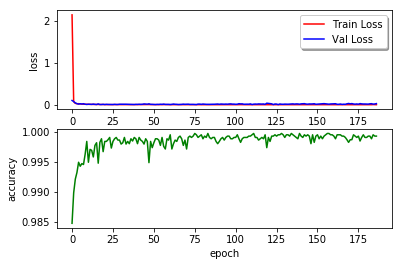

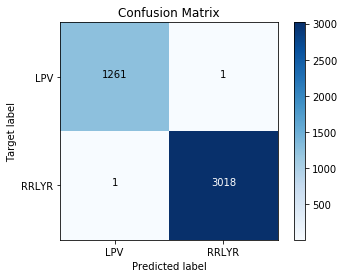

EPOCH: 188
TRAIN LOSS: 3.3242030116071697e-07
VAL LOSS: 0.013415438426294163
VAL ACCURACY: 99.9 %
TIME: 58.9 s


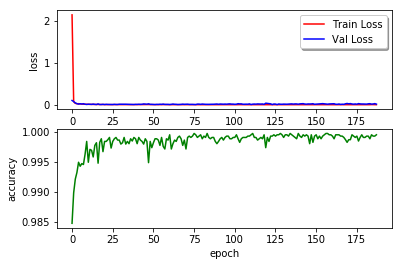

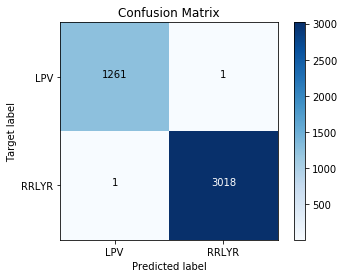

EPOCH: 189
TRAIN LOSS: 0.00017583760805560652
VAL LOSS: 0.014868576441787759
VAL ACCURACY: 99.9 %
TIME: 60.2 s


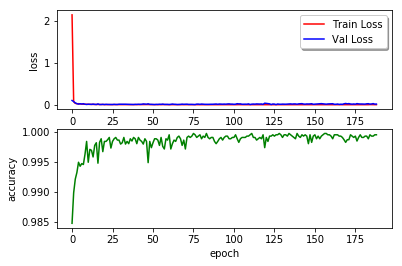

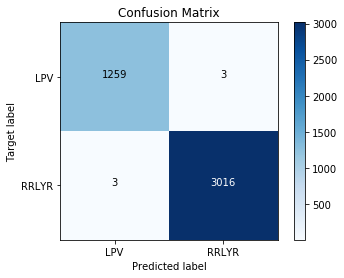

EPOCH: 190
TRAIN LOSS: 0.00047453054575943913
VAL LOSS: 0.02171675674875661
VAL ACCURACY: 99.9 %
TIME: 60.2 s


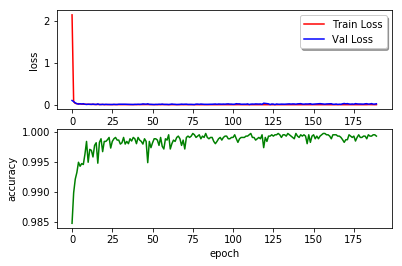

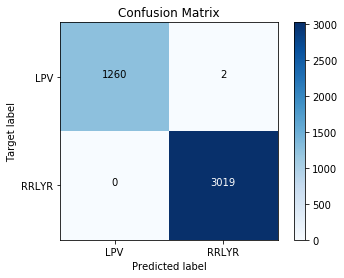

EPOCH: 191
TRAIN LOSS: 2.494793605675233e-06
VAL LOSS: 0.017261123598464715
VAL ACCURACY: 99.9 %
TIME: 64.1 s


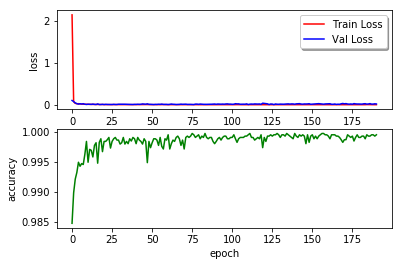

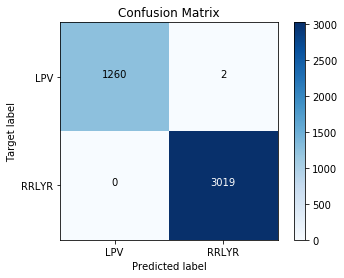

EPOCH: 192
TRAIN LOSS: 4.330192883657088e-05
VAL LOSS: 0.02357149423694943
VAL ACCURACY: 99.9 %
TIME: 58.4 s


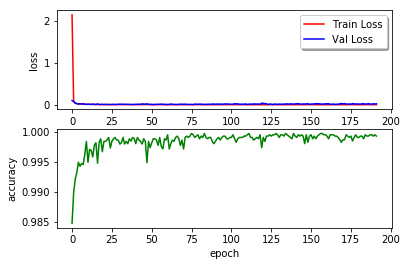

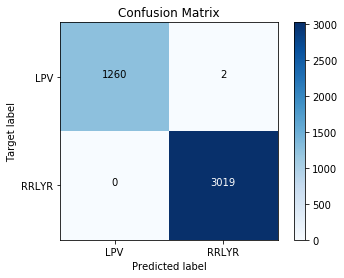

EPOCH: 193
TRAIN LOSS: 9.227558422151095e-06
VAL LOSS: 0.015121729187941422
VAL ACCURACY: 99.9 %
TIME: 60.8 s


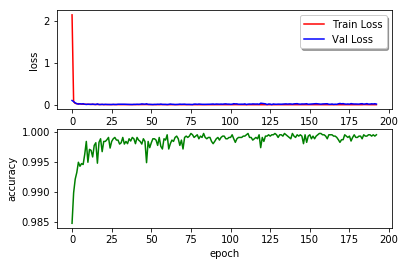

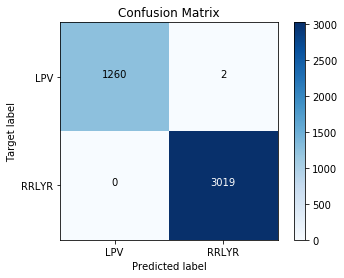

EPOCH: 194
TRAIN LOSS: 4.758493276477675e-07
VAL LOSS: 0.020119587750124287
VAL ACCURACY: 99.9 %
TIME: 59.7 s


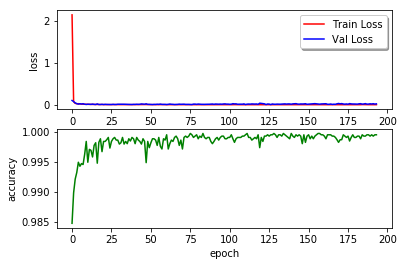

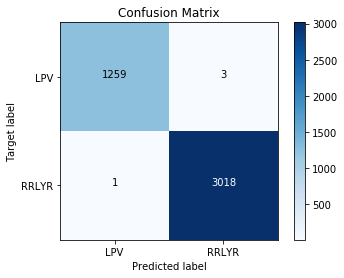

EPOCH: 195
TRAIN LOSS: 6.907784923583838e-07
VAL LOSS: 0.016383267286546255
VAL ACCURACY: 99.9 %
TIME: 60.5 s


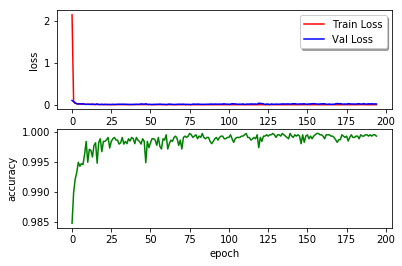

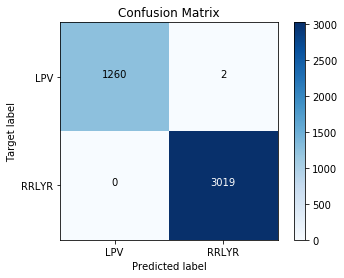

EPOCH: 196
TRAIN LOSS: 3.2607563547482106e-07
VAL LOSS: 0.01933833047845481
VAL ACCURACY: 99.9 %
TIME: 59.9 s


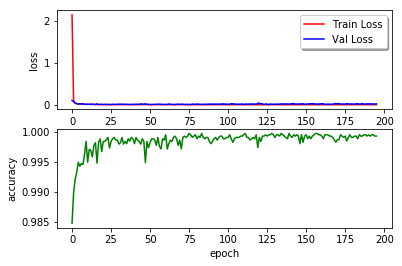

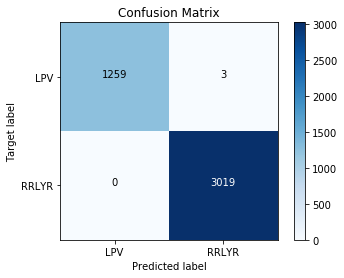

EPOCH: 197
TRAIN LOSS: 0.00011345239120423365
VAL LOSS: 0.034091793792274255
VAL ACCURACY: 99.9 %
TIME: 58.5 s


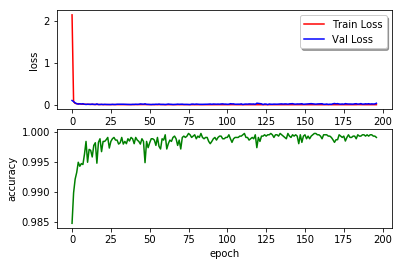

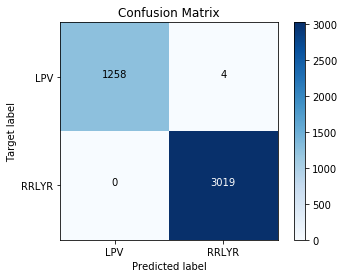

EPOCH: 198
TRAIN LOSS: 1.6098825303429303e-05
VAL LOSS: 0.014374982555430488
VAL ACCURACY: 99.9 %
TIME: 58.8 s


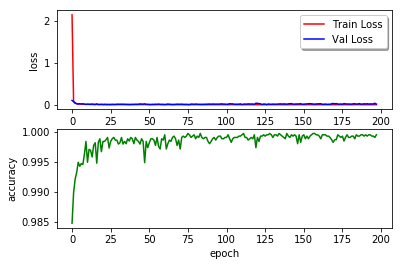

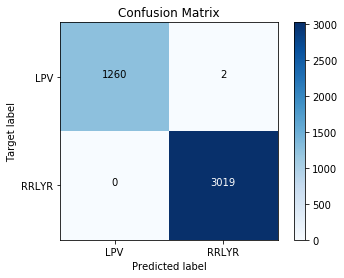

EPOCH: 199
TRAIN LOSS: 0.0003247745960273007
VAL LOSS: 0.020196258158362883
VAL ACCURACY: 99.8 %
TIME: 60.8 s


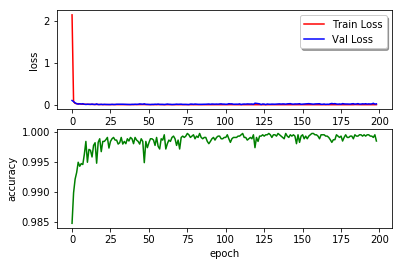

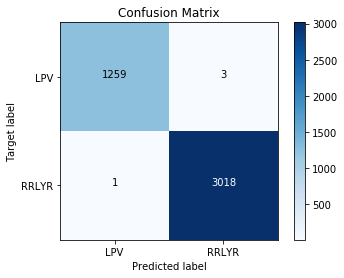

BEST VAL ACCURACY: 99.9 % EPOCH: 76
Final results:
  test loss:			4.428791
  test accuracy:		88.71 %
TRAINING DONE!


In [32]:
import time
import sklearn
import numpy 
import matplotlib.pyplot as plt
import numpy as np
###################### TRAINING #########################
print ("START TRAINING...")
train_loss = []
val_loss = []
val_accuracy = []
for epoch in range(1,200):
 
    #start timer
    start = time.time()
    
    #reset confusion matrix
    clearConfusionMatrix()
 
    #iterate over train split batches and calculate mean loss for epoch
    t_l = []
    for image_batch, target_batch in getNextImageBatch():
 
        #calling the training functions returns the current loss
        l = train_net(image_batch, target_batch)
        t_l.append(l)
 
    #we validate our net every epoch and pass our validation split through as well
    v_l = []
    v_a = []
    for image_batch, target_batch in getNextImageBatch(VAL):
  
        #calling the test function returns the net output, loss and accuracy
        prediction_batch, l, a = test_net(image_batch, target_batch)
        v_l.append(l)
        v_a.append(a)
         
        #save predicions and targets for confusion matrix
        
        updateConfusionMatrix(target_batch,prediction_batch)
    
    #mlxtend confusion matrix
    #cm=confusion_matrix(target_batch,prediction_batch)
    #    fig,ax=plot_confusion_matrix(conf_mat=cm)
      #  plt.show()
        
        #pandas_ml confusion matrix
        #confusion_matrix1 = ConfusionMatrix(target_batch,prediction_batch)
        #print("Confusion matrix:\n%s" % confusion_matrix1)
        
    #stop timer
    end = time.time()
 
    #calculate stats for epoch
    train_loss.append(np.mean(t_l))
    val_loss.append(np.mean(v_l))
    val_accuracy.append(np.mean(v_a))
 
    #print stats for epoch
    print ("EPOCH:", epoch,)
    print ("TRAIN LOSS:", train_loss[-1],)
    print ("VAL LOSS:", val_loss[-1],)
    print ("VAL ACCURACY:", (int(val_accuracy[-1] * 1000) / 10.0), "%",)
    print ("TIME:", (int((end - start) * 10) / 10.0), "s")
 
    #show chart
    showChart(epoch, train_loss, val_loss, val_accuracy)
    
    #show confusion matrix
    showConfusionMatrix()

    #show best accuracy and epoch
print ("BEST VAL ACCURACY:", (int(max(val_accuracy) * 1000) / 10.0), "%", "EPOCH:", val_accuracy.index(max(val_accuracy)) + 1)

#####TESTING DATA#######
test_err = 0
test_acc = 0
test_batches = 0
for image_batch, target_batch in getNextImageBatch1():
    test_batch, err, acc = test_net(image_batch, target_batch)
    test_err += err
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))
print ("TRAINING DONE!") 

In [73]:
from sklearn.utils.class_weight import compute_sample_weight
y =  ['ACEP', 'CEP', 'DSCT', 'ECL', 'LPV', 'RRLYR', 'T2CEP']
compute_sample_weight(class_weight='unbalanced', y=y)

array([1., 1., 1., 1., 1., 1., 1.])

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cm, classes=[0, 1],
                      title='Confusion matrix')